In [ ]:
#https://github.com/Whoami666/ML_practice/tree/main/Aachen_ML

In [ ]:
!pip install catboost

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.colors import ListedColormap, BoundaryNorm
from sklearn.preprocessing import StandardScaler

from sklearn.manifold import MDS, TSNE
from sklearn.decomposition import PCA

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, accuracy_score, rand_score, silhouette_score, davies_bouldin_score
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from imblearn.over_sampling import SMOTE
from catboost import CatBoostClassifier, Pool, cv, CatBoostRegressor

from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN

In [ ]:
import random
random.seed(42)

• node: Involvement of lymph nodes (0=no, 1=yes)

• grade: Histologic grade (Elston-Ellis) category

• size: Tumor size (in centimeters)

• age: Age of the patient (in years)

• er: Estrogen receptor (ER) status (0=negative, 1=positive)

• relapse: Relapse after surgery (0=no, 1=yes)

## Inputs

In [ ]:
gen_df = pd.read_csv("/content/mammacarcinoma_gex.csv")
gen_df.head()

patient_id     DDR1    RFC2   HSPA6    PAX8  GUCA1A    THRA  PTPN21  \
0           0   9.2048  6.3038  7.7602  7.9725  4.2653  2.9992  3.6423   
1           1  10.0090  5.8149  6.7343  7.9232  3.5011  5.2618  4.3622   
2           2   8.6175  5.9355  5.8762  6.5176  2.5346  6.0643  4.6878   
3           3   9.6734  7.0122  5.5486  8.0859  4.2885  4.9998  2.9966   
4           4   9.0900  6.0937  6.6429  7.9868  3.2729  5.4990  2.0513   

    EPHB3   ESRRA  ...  CASP8AP2    POLM    KLK5  SH3BP4   SPO11     TRDN  \
0  6.9242  6.9467  ...    5.8878  2.5847  6.1013  8.4443  3.1510  1.83220   
1  6.9789  6.5636  ...    6.7993  5.5474  6.3789  8.3950  3.1339  1.90000   
2  7.2233  6.2347  ...    6.5924  4.5240  7.2288  8.0967  3.1499 -1.16120   
3  6.1568  6.6900  ...    6.5698  4.6732  5.3107  9.1025  3.1123 -0.63409   
4  6.7127  6.7884  ...    5.7934  5.0880  5.2918  7.3995  4.1385 -0.47459   

   DKFZP564C196   YDD19     TAZ   GMEB2  
0       3.38240  3.7738  5.6098  7.2277  
1       3.25240  3.2802  6.2927  7.2210  
2       2.68950  3.6827  5.5525  6.6015  
3       2.66560  3.4840  6.4214  7.7900  
4      -0.89478  2.7115  6.4785  7.1017  

[5 rows x 6385 columns]

In [ ]:
df = pd.read_csv("/content/mammacarcinoma_pat.csv")
df.head()

patient_id  node  grade  size   age   er  relapse
0           0   0.0    NaN   0.0  44.0  1.0      0.0
1           1   0.0    NaN   0.3  61.0  1.0      0.0
2           2   0.0    NaN   1.5  53.0  1.0      0.0
3           3   0.0    3.0   3.0  62.0  1.0      1.0
4           4   NaN    3.0   NaN   NaN  1.0      0.0

# Part 0 — Orient Yourself

• Briefly describe and plot the data (dimensions, missingness, basic distributions, class
balance).

• If you filter/transform features (e.g., scaling, variance or MAD filtering), say what you did and why (1–2 sentences).

• Keep this section short; aim for 1–2 clear figures or tables.

## Overall overview

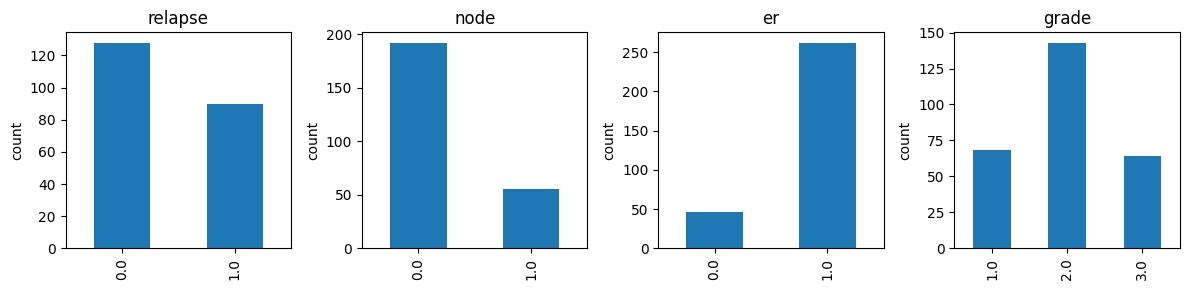

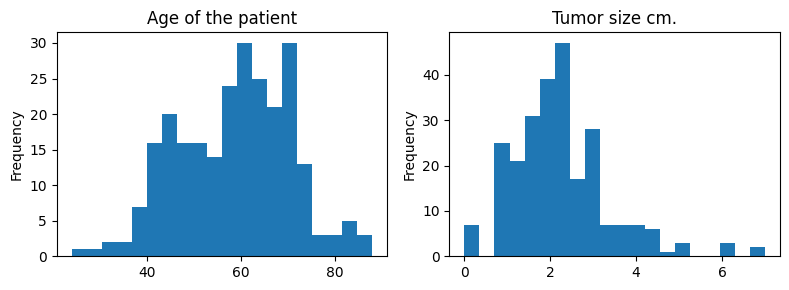

In [ ]:

# ---------- Figure 1: Categorical distributions ----------
fig, axes = plt.subplots(1, 4, figsize=(12, 3))

for ax, col in zip(axes, ["relapse", "node", "er", "grade"]):
    df[col].value_counts().sort_index().plot(kind="bar", ax=ax)
    ax.set_title(col)
    ax.set_xlabel("")
    ax.set_ylabel("count")

plt.tight_layout()
plt.show()

# ---------- Figure 2: Continuous distributions ----------
fig, axes = plt.subplots(1, 2, figsize=(8, 3))

df["age"].plot(kind="hist", bins=20, ax=axes[0])
axes[0].set_title("Age of the patient")

df["size"].plot(kind="hist", bins=20, ax=axes[1])
axes[1].set_title("Tumor size cm.")

plt.tight_layout()
plt.show()


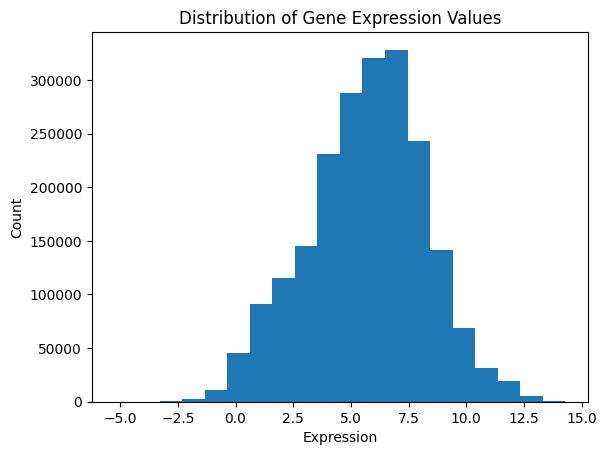

In [ ]:

gen_df.drop(columns="patient_id").stack().plot(kind="hist", bins=20)
plt.title("Distribution of Gene Expression Values")
plt.xlabel("Expression")
plt.ylabel("Count")
plt.show()


## Missing values

In [ ]:
df.isna().agg(["sum", "mean"]).T.rename(columns={"sum": "missing_cnt", "mean": "missing_ratio"})

missing_cnt  missing_ratio
patient_id          0.0       0.000000
node               80.0       0.244648
grade              52.0       0.159021
size               76.0       0.232416
age                75.0       0.229358
er                 19.0       0.058104
relapse           109.0       0.333333

In [ ]:
df.isna().sum(axis=1).sort_values(ascending=False)

291    6
141    6
106    6
70     6
80     6
      ..
300    0
321    0
324    0
325    0
326    0
Length: 327, dtype: int64

In [ ]:
df.isna().sum(axis=1).value_counts().sort_index()

0    173
1     67
2     12
3      2
4     61
5      2
6     10
Name: count, dtype: int64

In [ ]:
df.mean(numeric_only=True).to_frame(name="mean")

mean
patient_id  163.000000
node          0.222672
grade         1.985455
size          2.224745
age          58.666667
er            0.850649
relapse       0.412844

In [ ]:
df["age"] = df["age"].mean()

In [ ]:
df.isna().sum(axis=1).value_counts().sort_index()

0    173
1     67
2     14
3     61
4      2
5     10
Name: count, dtype: int64

In [ ]:
df = df[df.isna().sum(axis=1) != 5]
df.isna().sum(axis=1).value_counts().sort_index()

0    173
1     67
2     14
3     61
4      2
Name: count, dtype: int64

In [ ]:
df = df[df.isna().sum(axis=1) != 4]
df.isna().sum(axis=1).value_counts().sort_index()

0    173
1     67
2     14
3     61
Name: count, dtype: int64

In [ ]:
gen_df.isna().agg(["sum", "mean"]).T \
    .rename(columns={"sum": "missing_cnt", "mean": "missing_%"} ) \
    .sort_values(by="missing_cnt", ascending=False)


missing_cnt  missing_%
GMEB2           0.0        0.0
PRND            0.0        0.0
GTF2H3          0.0        0.0
ATF1            0.0        0.0
GSTA3           0.0        0.0
...             ...        ...
GUCA1A          0.0        0.0
PAX8            0.0        0.0
HSPA6           0.0        0.0
RFC2            0.0        0.0
DDR1            0.0        0.0

[6385 rows x 2 columns]

In [ ]:
df["er"] = df["er"].fillna(1)
df["node"] = df["node"].fillna(0)
df["relapse"] = df["relapse"].fillna(0)
df["grade"] = df["grade"].fillna(2)
df["size"] = df["size"].fillna(2.2)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 315 entries, 0 to 326
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   patient_id  315 non-null    int64  
 1   node        315 non-null    float64
 2   grade       315 non-null    float64
 3   size        315 non-null    float64
 4   age         315 non-null    float64
 5   er          315 non-null    float64
 6   relapse     315 non-null    float64
dtypes: float64(6), int64(1)
memory usage: 19.7 KB


## Merging

In [ ]:
df_whole = df.merge(gen_df, on="patient_id", how="left")
df_whole.head()

patient_id  node  grade  size        age   er  relapse     DDR1    RFC2  \
0           0   0.0    2.0   0.0  58.666667  1.0      0.0   9.2048  6.3038   
1           1   0.0    2.0   0.3  58.666667  1.0      0.0  10.0090  5.8149   
2           2   0.0    2.0   1.5  58.666667  1.0      0.0   8.6175  5.9355   
3           3   0.0    3.0   3.0  58.666667  1.0      1.0   9.6734  7.0122   
4           4   0.0    3.0   2.2  58.666667  1.0      0.0   9.0900  6.0937   

    HSPA6  ...  CASP8AP2    POLM    KLK5  SH3BP4   SPO11     TRDN  \
0  7.7602  ...    5.8878  2.5847  6.1013  8.4443  3.1510  1.83220   
1  6.7343  ...    6.7993  5.5474  6.3789  8.3950  3.1339  1.90000   
2  5.8762  ...    6.5924  4.5240  7.2288  8.0967  3.1499 -1.16120   
3  5.5486  ...    6.5698  4.6732  5.3107  9.1025  3.1123 -0.63409   
4  6.6429  ...    5.7934  5.0880  5.2918  7.3995  4.1385 -0.47459   

   DKFZP564C196   YDD19     TAZ   GMEB2  
0       3.38240  3.7738  5.6098  7.2277  
1       3.25240  3.2802  6.2927  7.2210  
2       2.68950  3.6827  5.5525  6.6015  
3       2.66560  3.4840  6.4214  7.7900  
4      -0.89478  2.7115  6.4785  7.1017  

[5 rows x 6391 columns]

In [ ]:
df_whole.isna().sum(axis=1).value_counts().sort_index()

0    315
Name: count, dtype: int64

## Duplicates

In [ ]:
#full duplicates
df[df.duplicated]

Empty DataFrame
Columns: [patient_id, node, grade, size, age, er, relapse]
Index: []

In [ ]:
#id duplicates
df[df.duplicated(subset=['patient_id'])]

Empty DataFrame
Columns: [patient_id, node, grade, size, age, er, relapse]
Index: []

In [ ]:
#full duplicates
gen_df[gen_df.duplicated]

Empty DataFrame
Columns: [patient_id, DDR1, RFC2, HSPA6, PAX8, GUCA1A, THRA, PTPN21, EPHB3, ESRRA, CYP2A6, MMP14, TRADD, FNTB, PLD1, PMS2L11, BAD, RPL35, RPL28, EIF4G2, SRP14, GDI2, RPL11, ARF3, RPL24, RPS13, Unnamed: 25, TARDBP, CFL1, RPL18, RPS5, RPL27, RPL34, NARS, RPL19, RPS11, RPL9, DDX5, RPL6, RPL10A, RPL17, PSMB2, BAT1, ERH, SFRS9, ABCF1, DAD1, YY1, JTB, ZNF146, SART1, ILF2, SPAG7, ZNF259, C1D, NONO, RNPS1, RPS24, RPL30, NPM1, ARF1, IK, SNX3, CANX, GUK1, OAZ1, RPS6, USP22, TCEB2, RPL12, RPL4, FNTA, RPS25, RPL37, EEF2, RPS10, ANAPC5, RPS3A, MSN, ACTN4, APP, PRKAR1A, DSP, RAD21, WDR1, NCL, AP2B1, AP2M1, CLTC, LASP1, SF3B2, CSRP1, MATR3, WARS, SET, NDRG1, PFN1, PTPRF, YWHAZ, SOD1, ...]
Index: []

[0 rows x 6385 columns]

In [ ]:
#id duplicates
gen_df[gen_df.duplicated(subset=['patient_id'])]

Empty DataFrame
Columns: [patient_id, DDR1, RFC2, HSPA6, PAX8, GUCA1A, THRA, PTPN21, EPHB3, ESRRA, CYP2A6, MMP14, TRADD, FNTB, PLD1, PMS2L11, BAD, RPL35, RPL28, EIF4G2, SRP14, GDI2, RPL11, ARF3, RPL24, RPS13, Unnamed: 25, TARDBP, CFL1, RPL18, RPS5, RPL27, RPL34, NARS, RPL19, RPS11, RPL9, DDX5, RPL6, RPL10A, RPL17, PSMB2, BAT1, ERH, SFRS9, ABCF1, DAD1, YY1, JTB, ZNF146, SART1, ILF2, SPAG7, ZNF259, C1D, NONO, RNPS1, RPS24, RPL30, NPM1, ARF1, IK, SNX3, CANX, GUK1, OAZ1, RPS6, USP22, TCEB2, RPL12, RPL4, FNTA, RPS25, RPL37, EEF2, RPS10, ANAPC5, RPS3A, MSN, ACTN4, APP, PRKAR1A, DSP, RAD21, WDR1, NCL, AP2B1, AP2M1, CLTC, LASP1, SF3B2, CSRP1, MATR3, WARS, SET, NDRG1, PFN1, PTPRF, YWHAZ, SOD1, ...]
Index: []

[0 rows x 6385 columns]

# Part I — Dimensionality Reduction

• Choose how to represent the data (raw genes, PCA, other dimensionality reduction, or learned embedding). Explore at least two different dimensionality reduction techniques.

• Justify the choice in one paragraph.

• Provide compact visualizations and one small quantitative check that the
representation is useful for downstream tasks (you decide the check).


In [ ]:
print("Samples:", df_whole.shape[0])
print("Features:", df_whole.shape[1] - 1)  # minus patient_id


Samples: 315
Features: 6390


## ER

In [ ]:
X = df_whole.drop(columns=["patient_id", "er"])
y = df_whole["er"]

In [ ]:
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)

In [ ]:
def n_components_pca(method):
  plt.figure(figsize=(14, 4))

  X_pca = method.fit_transform(X_scaled)
  PC_values = np.arange(method.n_components_) + 1

  plt.subplot(1,2,1)
  plt.plot(PC_values, method.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
  plt.title(f'Scree Plot for {method}')
  plt.xlabel('Principal Component')
  plt.ylabel('Variance Explained')


  plt.subplot(1,2,2)
  cum_var = np.cumsum(method.explained_variance_ratio_)
  plt.plot(PC_values, cum_var, 'o-')
  plt.axhline(0.8, linestyle='--')
  plt.axhline(0.9, linestyle='--')
  plt.xlabel("Number of components")
  plt.ylabel("Cumulative variance explained")
  plt.title("Cumulative Explained Variance")
  plt.show()

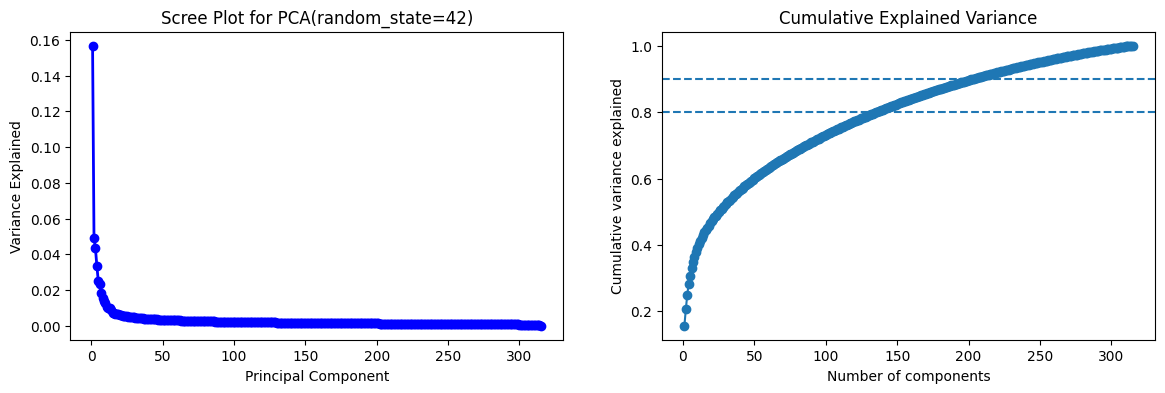

In [ ]:
n_components_pca(PCA(random_state=42))

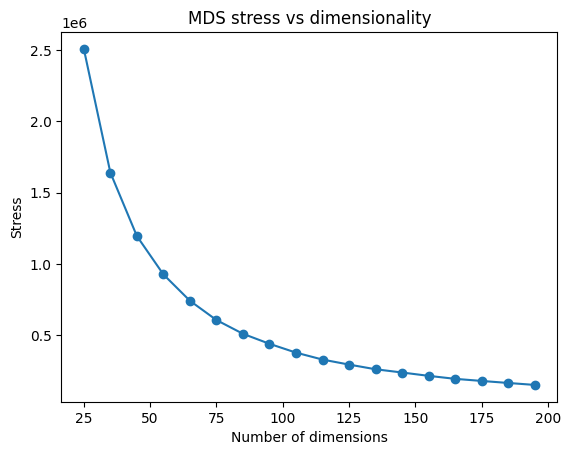

In [ ]:
stress = []
dims = range(25, 200, 10) #was too great for less than 25

for d in dims:
    mds = MDS(n_components=d, random_state=42, normalized_stress="auto")
    mds.fit(X_scaled)
    stress.append(mds.stress_)

plt.plot(dims, stress, 'o-')
plt.xlabel("Number of dimensions")
plt.ylabel("Stress")
plt.title("MDS stress vs dimensionality")
plt.show()


In [ ]:
# PCA to 2D
pca = PCA(n_components=3, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# run the tSNE algorithm
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

#MDS
mds = MDS(n_components=3, random_state=42)
X_mds = mds.fit_transform(X_scaled)

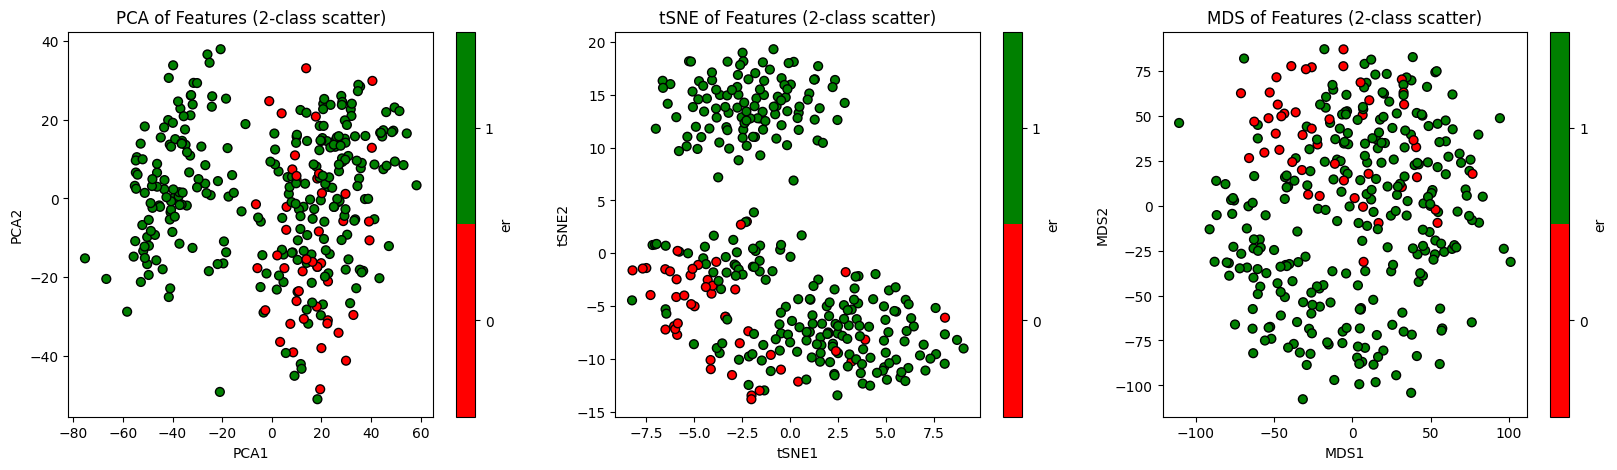

In [ ]:
cmap = ListedColormap(["red", "green"])

def draw_plot(x_transformed, method):
    scatter = plt.scatter(
    x_transformed[:,0],
    x_transformed[:,1],
    c=y,
    cmap=cmap,
    edgecolor="k",
    s=40
    )
    plt.xlabel(f"{method}1")
    plt.ylabel(f"{method}2")
    plt.title(f"{method} of Features (2-class scatter)")
    cbar = plt.colorbar(scatter)
    cbar.set_ticks([0.25, 0.75])
    cbar.set_ticklabels(["0", "1"])
    cbar.set_label("er")

plt.figure(figsize=(20, 5))

plt.subplot(1,3,1)
draw_plot(X_pca, "PCA")

plt.subplot(1,3,2)
draw_plot(X_tsne, "tSNE")

plt.subplot(1,3,3)
draw_plot(X_mds, "MDS")


plt.show()

## Same for other features

### Grade

In [ ]:
X = df_whole.drop(columns=["patient_id", "grade"])

y = df_whole["grade"]

In [ ]:
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)

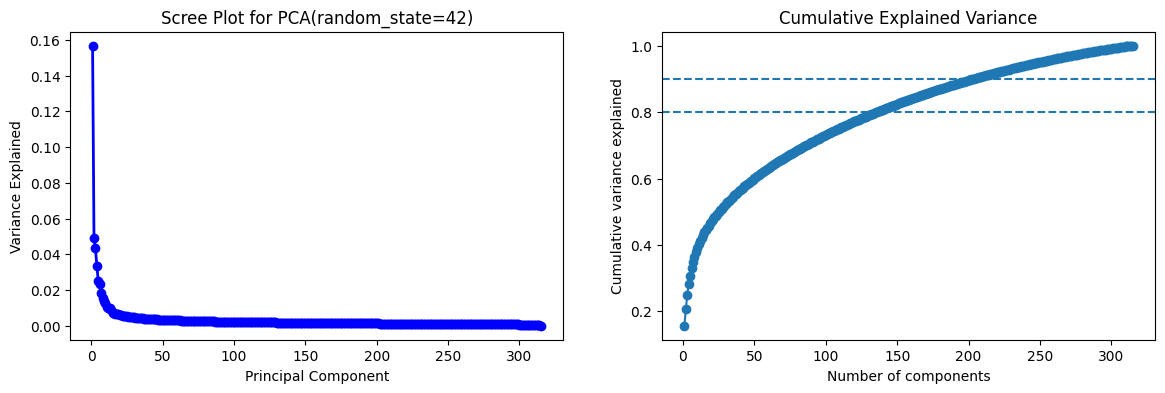

In [ ]:
n_components_pca(PCA(random_state=42))

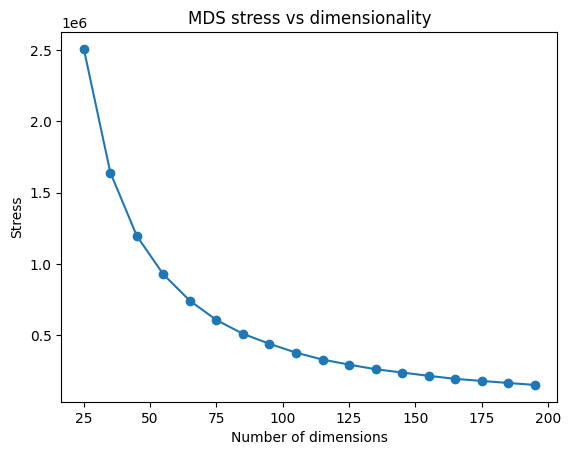

In [ ]:
stress = []
dims = range(25, 200, 10) #was too great for less than 25

for d in dims:
    mds = MDS(n_components=d, random_state=42, normalized_stress="auto")
    mds.fit(X_scaled)
    stress.append(mds.stress_)

plt.plot(dims, stress, 'o-')
plt.xlabel("Number of dimensions")
plt.ylabel("Stress")
plt.title("MDS stress vs dimensionality")
plt.show()


In [ ]:
# PCA to 2D
pca = PCA(n_components=3, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# run the tSNE algorithm
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

#MDS
mds = MDS(n_components=3, random_state=42)
X_mds = mds.fit_transform(X_scaled)

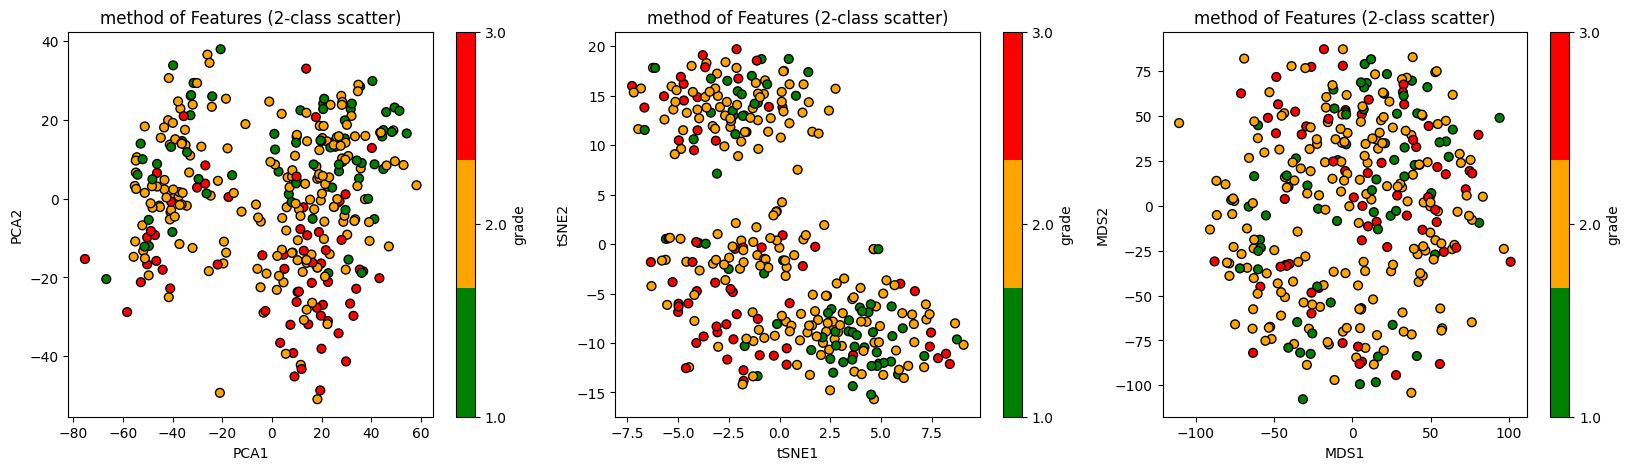

In [ ]:
cmap = ListedColormap(["green", "orange", "red"])

def draw_plot(x_transformed, method):
    scatter = plt.scatter(
    x_transformed[:,0],
    x_transformed[:,1],
    c=y,
    cmap=cmap,
    edgecolor="k",
    s=40
    )
    plt.xlabel(f"{method}1")
    plt.ylabel(f"{method}2")
    plt.title(f"method of Features (2-class scatter)")
    cbar = plt.colorbar(scatter)
    class_values = np.unique(y)
    cbar.set_ticks(class_values)
    cbar.set_ticklabels([str(c) for c in class_values])
   # cbar.set_ticks([1.5, 2.5, 3])
  #  cbar.set_ticklabels(["1", "2", "3"])
    cbar.set_label("grade")

plt.figure(figsize=(20, 5))

plt.subplot(1,3,1)
draw_plot(X_pca, "PCA")

plt.subplot(1,3,2)
draw_plot(X_tsne, "tSNE")

plt.subplot(1,3,3)
draw_plot(X_mds, "MDS")

plt.show()

### Relapse

In [ ]:
X = df_whole.drop(columns=["patient_id", "relapse"])
y = df_whole["relapse"]

In [ ]:
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)

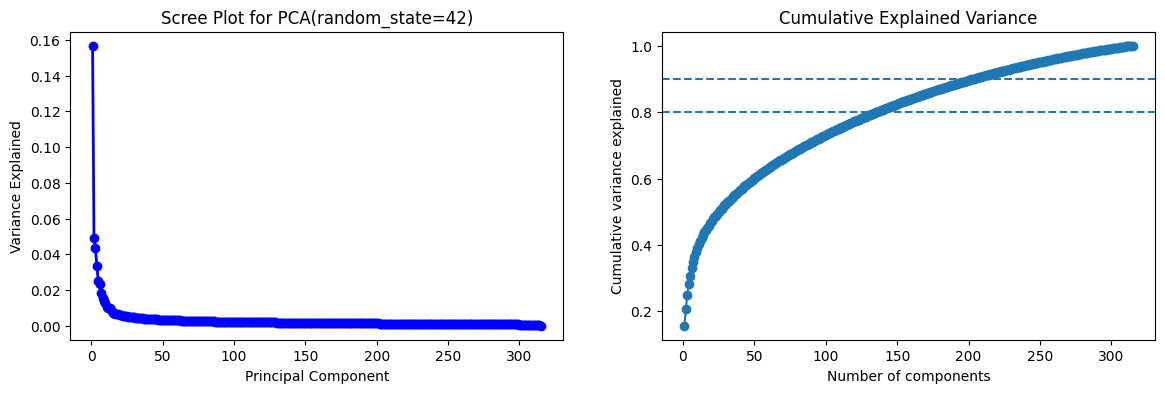

In [ ]:
n_components_pca(PCA(random_state=42))

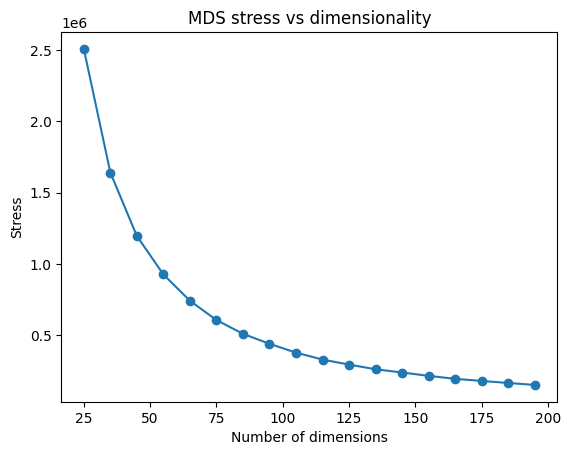

In [ ]:
stress = []
dims = range(25, 200, 10) #was too great for less than 25

for d in dims:
    mds = MDS(n_components=d, random_state=42, normalized_stress="auto")
    mds.fit(X_scaled)
    stress.append(mds.stress_)

plt.plot(dims, stress, 'o-')
plt.xlabel("Number of dimensions")
plt.ylabel("Stress")
plt.title("MDS stress vs dimensionality")
plt.show()


In [ ]:
# PCA to 2D
pca = PCA(n_components=3, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# run the tSNE algorithm
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

#MDS
mds = MDS(n_components=3, random_state=42)
X_mds = mds.fit_transform(X_scaled)

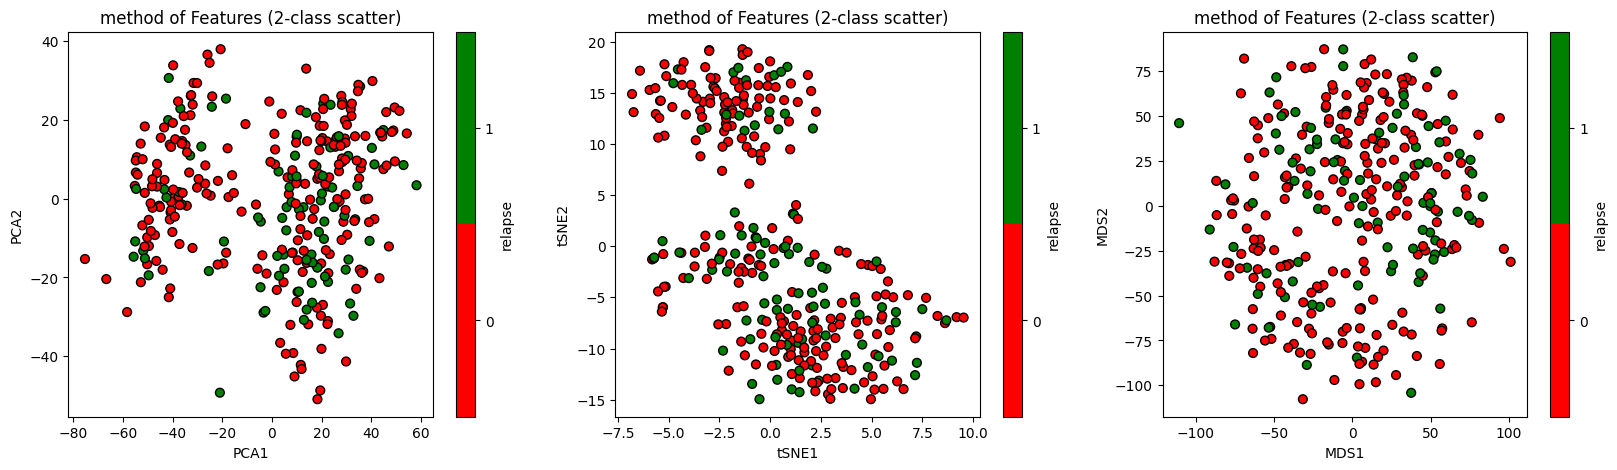

In [ ]:
cmap = ListedColormap(["red", "green"])

def draw_plot(x_transformed, method):
    scatter = plt.scatter(
    x_transformed[:,0],
    x_transformed[:,1],
    c=y,
    cmap=cmap,
    edgecolor="k",
    s=40
    )
    plt.xlabel(f"{method}1")
    plt.ylabel(f"{method}2")
    plt.title(f"method of Features (2-class scatter)")
    cbar = plt.colorbar(scatter)
    cbar.set_ticks([0.25, 0.75])
    cbar.set_ticklabels(["0", "1"])
    cbar.set_label("relapse")

plt.figure(figsize=(20, 5))

plt.subplot(1,3,1)
draw_plot(X_pca, "PCA")

plt.subplot(1,3,2)
draw_plot(X_tsne, "tSNE")

plt.subplot(1,3,3)
draw_plot(X_mds, "MDS")


plt.show()

### Node

In [ ]:
X = df_whole.drop(columns=["patient_id", "node"])
y = df_whole["node"]

In [ ]:
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)

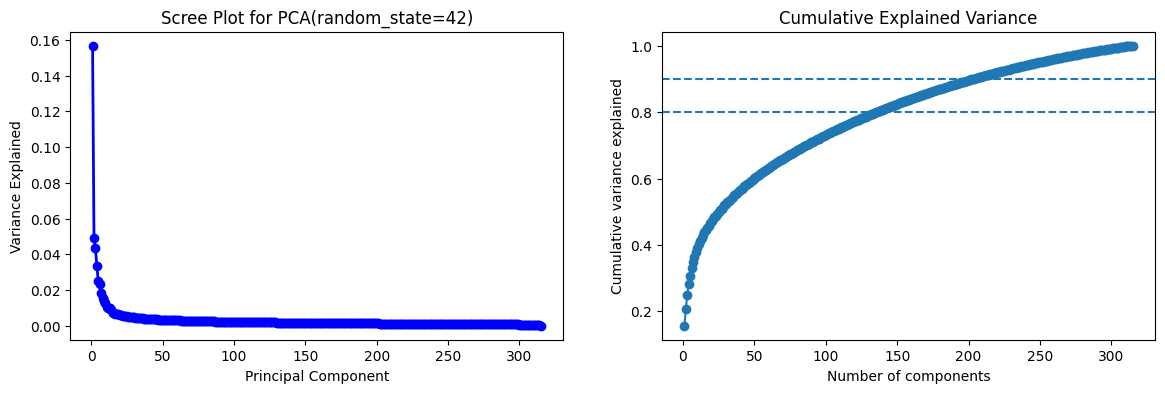

In [ ]:
n_components_pca(PCA(random_state=42))

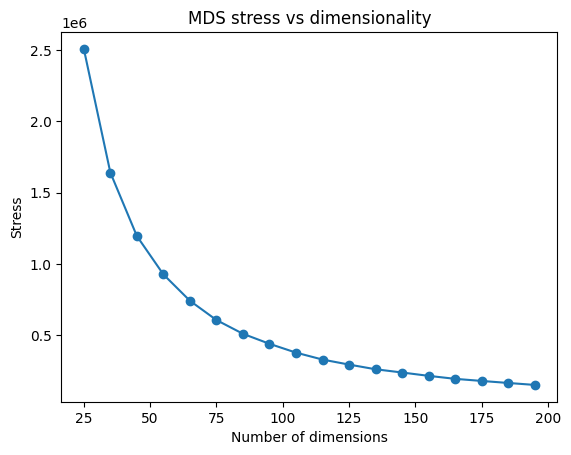

In [ ]:
stress = []
dims = range(25, 200, 10) #was too great for less than 25

for d in dims:
    mds = MDS(n_components=d, random_state=42, normalized_stress="auto")
    mds.fit(X_scaled)
    stress.append(mds.stress_)

plt.plot(dims, stress, 'o-')
plt.xlabel("Number of dimensions")
plt.ylabel("Stress")
plt.title("MDS stress vs dimensionality")
plt.show()


In [ ]:
# PCA to 2D
pca = PCA(n_components=3, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# run the tSNE algorithm
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

#MDS
mds = MDS(n_components=3, random_state=42)
X_mds = mds.fit_transform(X_scaled)

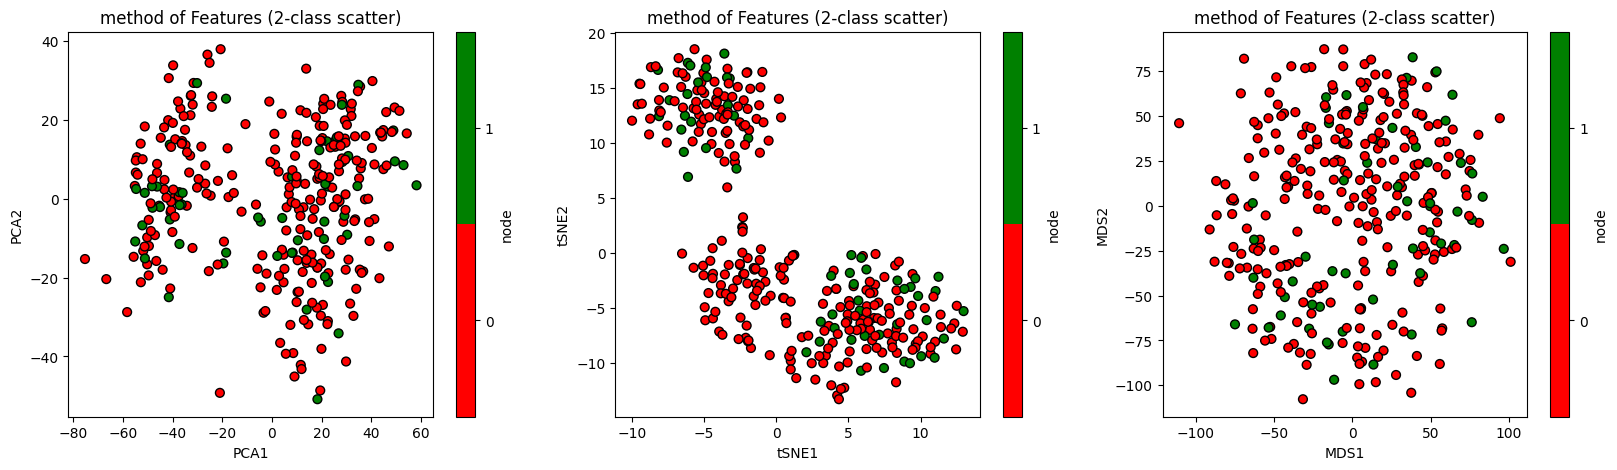

In [ ]:
cmap = ListedColormap(["red", "green"])

def draw_plot(x_transformed, method):
    scatter = plt.scatter(
    x_transformed[:,0],
    x_transformed[:,1],
    c=y,
    cmap=cmap,
    edgecolor="k",
    s=40
    )
    plt.xlabel(f"{method}1")
    plt.ylabel(f"{method}2")
    plt.title(f"method of Features (2-class scatter)")
    cbar = plt.colorbar(scatter)
    cbar.set_ticks([0.25, 0.75])
    cbar.set_ticklabels(["0", "1"])
    cbar.set_label("node")

plt.figure(figsize=(20, 5))

plt.subplot(1,3,1)
draw_plot(X_pca, "PCA")

plt.subplot(1,3,2)
draw_plot(X_tsne, "tSNE")

plt.subplot(1,3,3)
draw_plot(X_mds, "MDS")


plt.show()

### Size

In [ ]:
X = df_whole.drop(columns=["patient_id", "size"])

y = df_whole["size"]

In [ ]:
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)

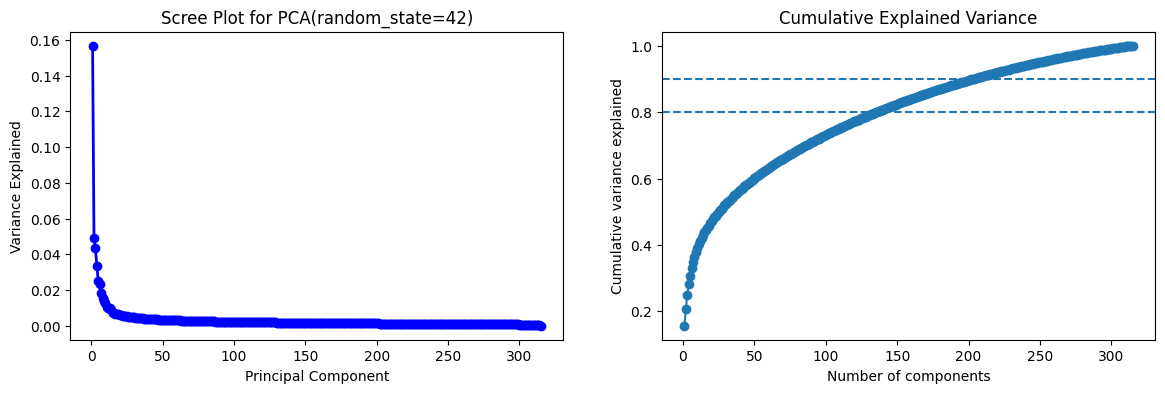

In [ ]:
n_components_pca(PCA(random_state=42))

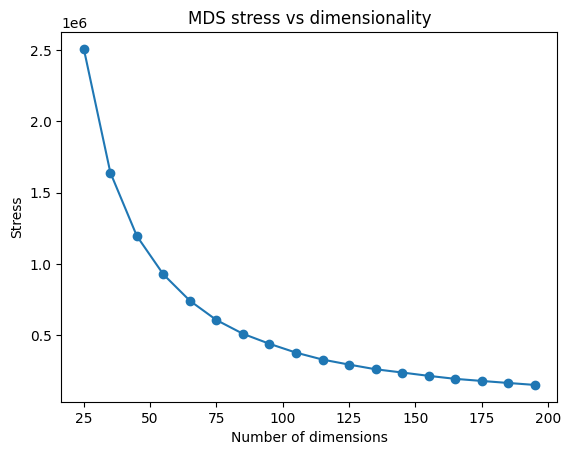

In [ ]:
stress = []
dims = range(25, 200, 10) #was too great for less than 25

for d in dims:
    mds = MDS(n_components=d, random_state=42, normalized_stress="auto")
    mds.fit(X_scaled)
    stress.append(mds.stress_)

plt.plot(dims, stress, 'o-')
plt.xlabel("Number of dimensions")
plt.ylabel("Stress")
plt.title("MDS stress vs dimensionality")
plt.show()


In [ ]:
# PCA to 2D
pca = PCA(n_components=3, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# run the tSNE algorithm
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

#MDS
mds = MDS(n_components=3, random_state=42)
X_mds = mds.fit_transform(X_scaled)

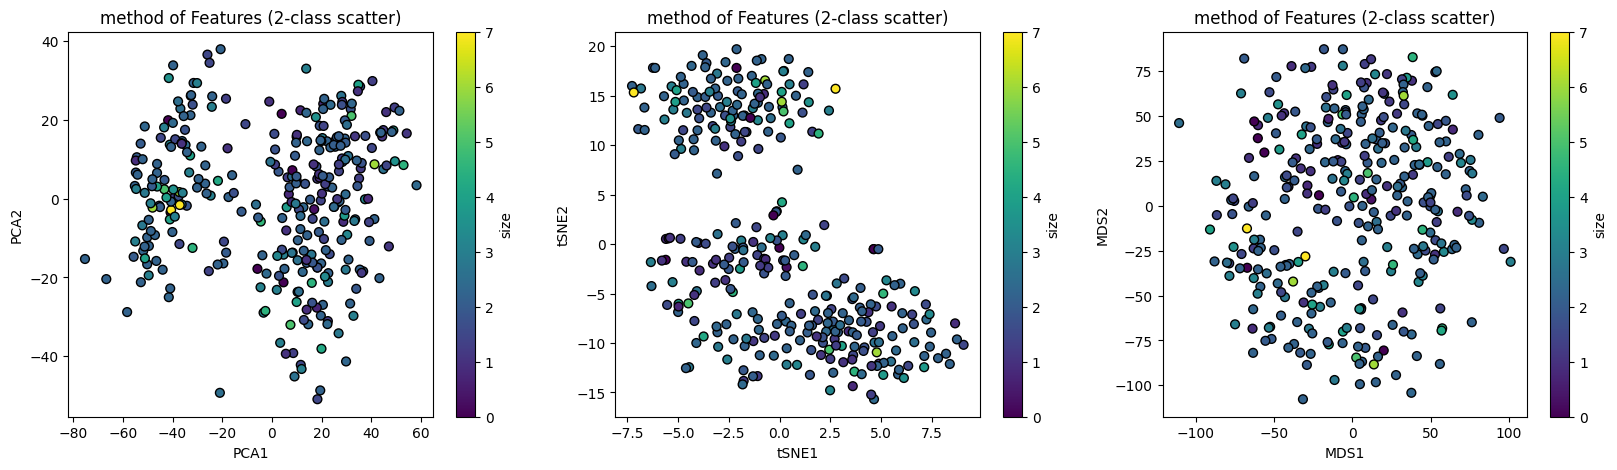

In [ ]:
def draw_plot(x_transformed, method):
    scatter = plt.scatter(
    x_transformed[:,0],
    x_transformed[:,1],
    c=y,
   # cmap=cmap,
    edgecolor="k",
    s=40
    )
    plt.xlabel(f"{method}1")
    plt.ylabel(f"{method}2")
    plt.title(f"method of Features (2-class scatter)")
    cbar = plt.colorbar(scatter)
    cbar.set_label("size")

plt.figure(figsize=(20, 5))

plt.subplot(1,3,1)
draw_plot(X_pca, "PCA")

plt.subplot(1,3,2)
draw_plot(X_tsne, "tSNE")


plt.subplot(1,3,3)
draw_plot(X_mds, "MDS")


plt.show()

# Part II — Clustering

• Pick an algorithm and parameters/number of groups; defend briefly.

• Use at least one internal criterion (e.g., silhouette, Davies–Bouldin) and some notion of stability (e.g., resampling or different seeds).

• What do the clusters capture? Summarize key features per cluster, clinical differences,
and potential biological hypotheses.


In [ ]:
X = df_whole.drop(columns=["patient_id", "er"])
y = df_whole["er"]

X_scaled = scaler.fit_transform(X)

In [ ]:
# PCA to 2D
pca = PCA(n_components=140, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# run the tSNE algorithm
tsne = TSNE(n_components=3, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

#MDS
mds = MDS(n_components=150, random_state=42)
X_mds = mds.fit_transform(X_scaled)

## k-means

In [ ]:
cmap = ListedColormap(["red", "green"])
res_dict = {}

def draw_plot_kmeans(x_transformed, method, original=True):

    if not original:
      kmeans = KMeans(n_clusters=2, n_init=2, random_state=42).fit(x_transformed)
      y_k = kmeans.labels_

      smc = max(
          accuracy_score(y_k, y),
          accuracy_score(y_k, 1 - y)
      )

      rand = round(rand_score(y_k, y), 2)

      print(f'k-means {method}:')
      score = round(silhouette_score(X_scaled, y_k), 2)
      dbi = round(davies_bouldin_score(X_scaled, y_k), 2)
      print(f"Davies–Bouldin index: {dbi}, Silhouette score: {score}, Simple Matching Coefficient: {round(smc, 2)}, Rand Index: {rand}")

      res_dict[f"{method}, dbi"] = dbi
      res_dict[f"{method}, Silhouette"] = score

      scatter = plt.scatter(
      x_transformed[:,0],
      x_transformed[:,1],
      c=y_k,
      cmap=cmap,
      edgecolor="k",
      s=40
      )
      plt.title(f"{method} + k-means")
      plt.legend(handles=scatter.legend_elements()[0], labels=["0", "1"])

    else:
      scatter = plt.scatter(
      x_transformed[:, 0],
      x_transformed[:, 1],
      c=y,
      cmap=cmap,
      edgecolor="k",
      s=40,
      )
      plt.title(f'original data, {method}')
      plt.legend(handles=scatter.legend_elements()[0], labels=["0", "1"])



k-means tSNE:
Davies–Bouldin index: 2.69, Silhouette score: 0.12, Simple Matching Coefficient: 0.51, Rand Index: 0.5
k-means MDS:
Davies–Bouldin index: 2.45, Silhouette score: 0.15, Simple Matching Coefficient: 0.5, Rand Index: 0.5
k-means PCA:
Davies–Bouldin index: 2.45, Silhouette score: 0.15, Simple Matching Coefficient: 0.5, Rand Index: 0.5


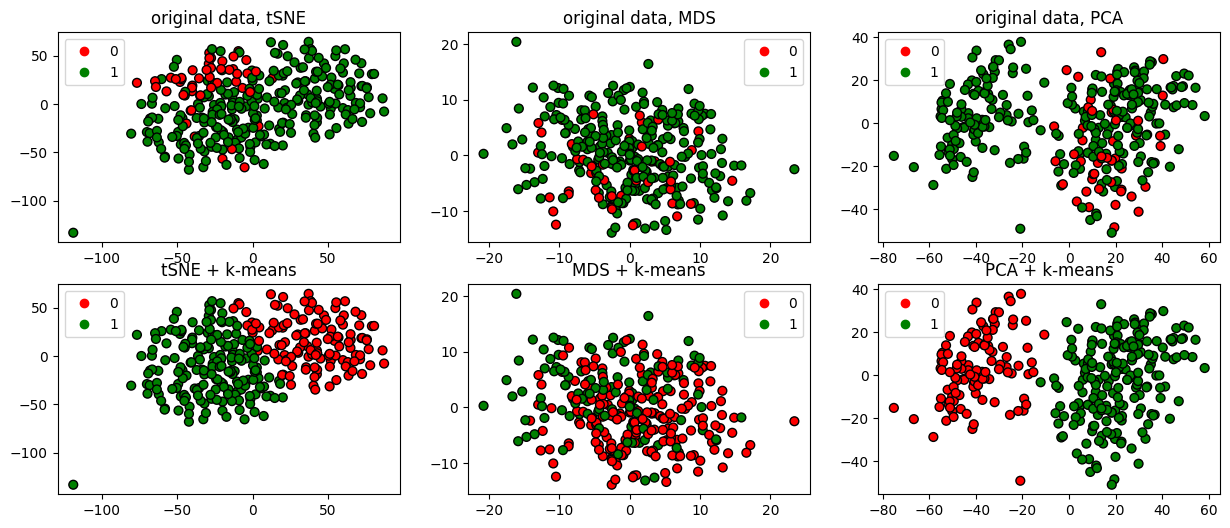

In [ ]:
plt.figure(figsize=(15, 6))

plt.subplot(2,3,1)
draw_plot_kmeans(X_tsne, "tSNE", original=True)

plt.subplot(2,3,4)
draw_plot_kmeans(X_tsne, "tSNE", original=False)

plt.subplot(2,3,2)
draw_plot_kmeans(X_mds, "MDS", original=True)

plt.subplot(2,3,5)
draw_plot_kmeans(X_mds, "MDS", original=False)

plt.subplot(2,3,3)
draw_plot_kmeans(X_pca, "PCA", original=True)

plt.subplot(2,3,6)
draw_plot_kmeans(X_pca, "PCA", original=False)

In [ ]:
cmap = ListedColormap(["red", "green"])
res_dict_new_rs = {}

def draw_plot_kmeans_new_rs(x_transformed, method, original=True):

    if not original:
      kmeans = KMeans(n_clusters=2, n_init=2, random_state=21).fit(x_transformed)
      y_k = kmeans.labels_

      smc = max(
          accuracy_score(y_k, y),
          accuracy_score(y_k, 1 - y)
      )

      rand = round(rand_score(y_k, y), 2)

      print(f'k-means {method}:')
      score = round(silhouette_score(X_scaled, y_k), 2)
      dbi = round(davies_bouldin_score(X_scaled, y_k), 2)
      print(f"Davies–Bouldin index: {dbi}, Silhouette score: {score}, Simple Matching Coefficient: {round(smc, 2)}, Rand Index: {rand}")

      res_dict_new_rs[f"{method}, dbi"] = dbi
      res_dict_new_rs[f"{method}, Silhouette"] = score

      scatter = plt.scatter(
      x_transformed[:,0],
      x_transformed[:,1],
      c=y_k,
      cmap=cmap,
      edgecolor="k",
      s=40
      )
      plt.title(f"{method} + k-means")
      plt.legend(handles=scatter.legend_elements()[0], labels=["0", "1"])

    else:
      scatter = plt.scatter(
      x_transformed[:, 0],
      x_transformed[:, 1],
      c=y,
      cmap=cmap,
      edgecolor="k",
      s=40,
      )
      plt.title(f'original data, {method}')
      plt.legend(handles=scatter.legend_elements()[0], labels=["0", "1"])


k-means tSNE:
Davies–Bouldin index: 2.69, Silhouette score: 0.12, Simple Matching Coefficient: 0.51, Rand Index: 0.5
k-means MDS:
Davies–Bouldin index: 2.45, Silhouette score: 0.15, Simple Matching Coefficient: 0.5, Rand Index: 0.5
k-means PCA:
Davies–Bouldin index: 2.45, Silhouette score: 0.15, Simple Matching Coefficient: 0.5, Rand Index: 0.5


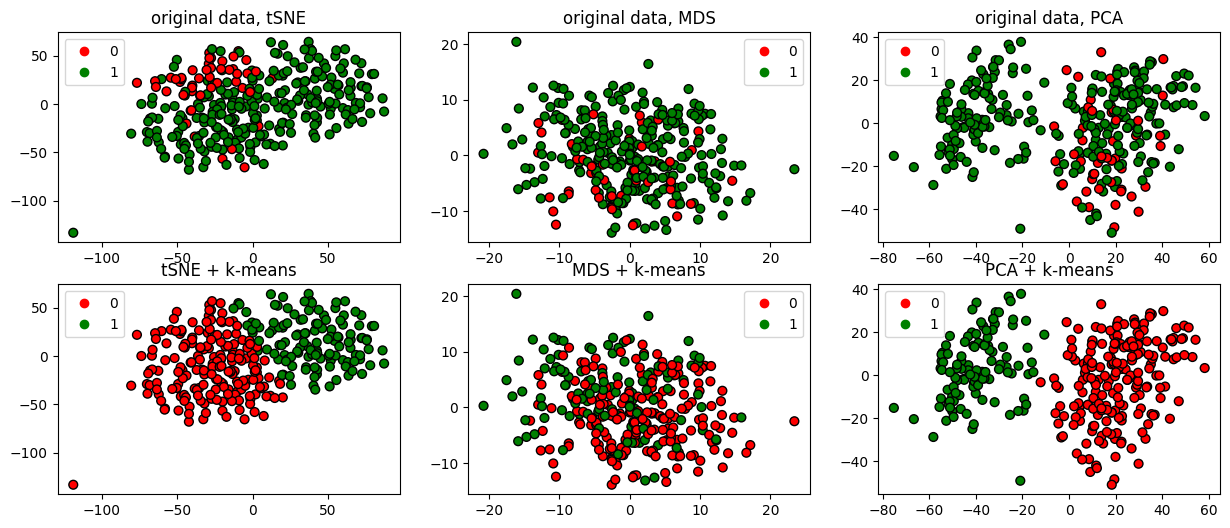

In [ ]:
plt.figure(figsize=(15, 6))

plt.subplot(2,3,1)
draw_plot_kmeans_new_rs(X_tsne, "tSNE", original=True)

plt.subplot(2,3,4)
draw_plot_kmeans_new_rs(X_tsne, "tSNE", original=False)

plt.subplot(2,3,2)
draw_plot_kmeans_new_rs(X_mds, "MDS", original=True)

plt.subplot(2,3,5)
draw_plot_kmeans_new_rs(X_mds, "MDS", original=False)

plt.subplot(2,3,3)
draw_plot_kmeans_new_rs(X_pca, "PCA", original=True)

plt.subplot(2,3,6)
draw_plot_kmeans_new_rs(X_pca, "PCA", original=False)

In [ ]:
res_dict_new_rs

{'tSNE, dbi': np.float64(2.69),
 'tSNE, Silhouette': np.float64(0.12),
 'MDS, dbi': np.float64(2.45),
 'MDS, Silhouette': np.float64(0.15),
 'PCA, dbi': np.float64(2.45),
 'PCA, Silhouette': np.float64(0.15)}

In [ ]:
res_dict

{'tSNE, dbi': np.float64(2.69),
 'tSNE, Silhouette': np.float64(0.12),
 'MDS, dbi': np.float64(2.45),
 'MDS, Silhouette': np.float64(0.15),
 'PCA, dbi': np.float64(2.45),
 'PCA, Silhouette': np.float64(0.15)}

In [ ]:
res_dict_new_rs == res_dict

True

## GaussianMixture

In [ ]:
cmap = ListedColormap(["red", "green"])
res_dict_gm = {}

def draw_plot_gm(x_transformed, method, original=True, covariance_type=None):

    if not original:
      y_gm = GaussianMixture(n_components=2, covariance_type=covariance_type, random_state=42).fit_predict(x_transformed)

      smc = max(
          accuracy_score(y_gm, y),
          accuracy_score(y_gm, 1 - y)
      )

      rand = round(rand_score(y_gm, y), 2)


      print(f'GaussianMixture {method}, {covariance_type}:')

      score = round(silhouette_score(X_scaled, y_gm), 2)
      dbi = round(davies_bouldin_score(X_scaled, y_gm), 2)
      print(f"Davies–Bouldin index: {dbi}, Silhouette score: {score}, Simple Matching Coefficient: {round(smc, 2)}, Rand Index: {rand}")


      res_dict[f"{method}, dbi"] = dbi
      res_dict[f"{method}, Silhouette"] = score

      scatter = plt.scatter(
      x_transformed[:,0],
      x_transformed[:,1],
      c=y_gm,
      cmap=cmap,
      edgecolor="k",
      s=40
      )
      plt.title(f"{method} + gm {covariance_type}")
      plt.legend(handles=scatter.legend_elements()[0], labels=["0", "1"])

    else:
      scatter = plt.scatter(
      x_transformed[:, 0],
      x_transformed[:, 1],
      c=y,
      cmap=cmap,
      edgecolor="k",
      s=40,
      )
      plt.title(f'original data, {method}')
      plt.legend(handles=scatter.legend_elements()[0], labels=["0", "1"])



GaussianMixture PCA, diag:
Davies–Bouldin index: 3.69, Silhouette score: 0.07, Simple Matching Coefficient: 0.52, Rand Index: 0.5
GaussianMixture PCA, spherical:
Davies–Bouldin index: 2.81, Silhouette score: 0.12, Simple Matching Coefficient: 0.5, Rand Index: 0.5
GaussianMixture PCA, tied:
Davies–Bouldin index: 2.45, Silhouette score: 0.15, Simple Matching Coefficient: 0.5, Rand Index: 0.5
GaussianMixture PCA, full:
Davies–Bouldin index: 2.45, Silhouette score: 0.15, Simple Matching Coefficient: 0.5, Rand Index: 0.5
k-means PCA:
Davies–Bouldin index: 2.45, Silhouette score: 0.15, Simple Matching Coefficient: 0.5, Rand Index: 0.5


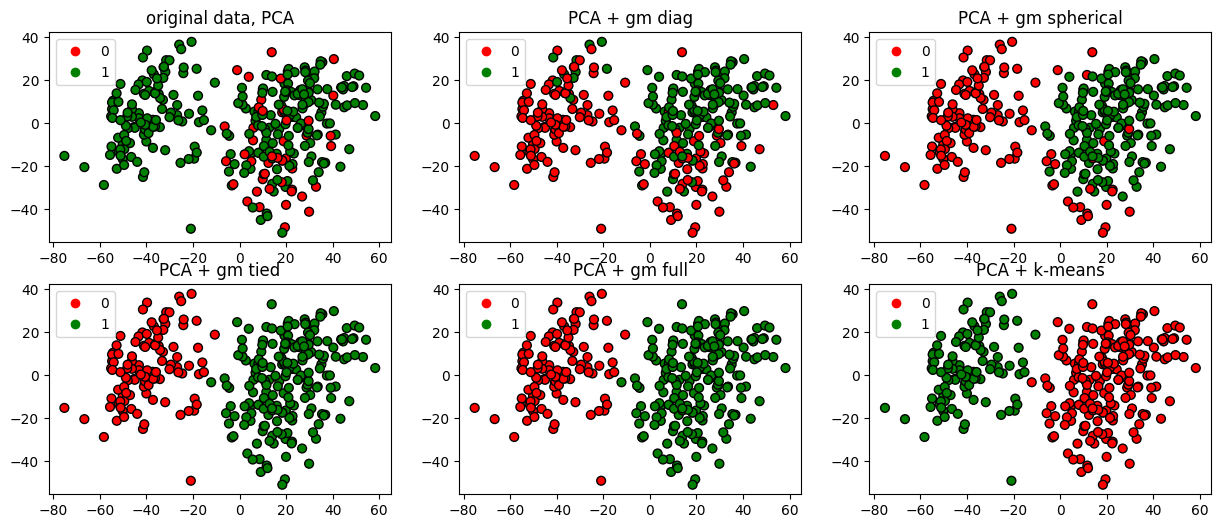

In [ ]:
plt.figure(figsize=(15, 6))

plt.subplot(2,3,1)
draw_plot_gm(X_pca, "PCA", original=True)

plt.subplot(2,3,2)
draw_plot_gm(X_pca, "PCA", original=False, covariance_type="diag")

plt.subplot(2,3,3)
draw_plot_gm(X_pca, "PCA", original=False, covariance_type="spherical")

plt.subplot(2,3,4)
draw_plot_gm(X_pca, "PCA", original=False, covariance_type="tied")

plt.subplot(2,3,5)
draw_plot_gm(X_pca, "PCA", original=False, covariance_type="full")

plt.subplot(2,3,6)
draw_plot_kmeans_new_rs(X_pca, "PCA", original=False)

## Same for other features

### Grade

In [ ]:
X = df_whole.drop(columns=["patient_id", "grade"])

y = df_whole["grade"]

X_scaled = scaler.fit_transform(X)

In [ ]:
cmap = ListedColormap(["green", "orange", "red"])

def draw_plot_gm(x_transformed, method, original=True, covariance_type=None):

    if not original:
      y_gm = GaussianMixture(n_components=3, covariance_type=covariance_type, random_state=42).fit_predict(x_transformed)

      smc = max(
          accuracy_score(y_gm, y),
          accuracy_score(y_gm, 1 - y)
      )

      rand = round(rand_score(y_gm, y), 2)


      print(f'GaussianMixture {method}, {covariance_type}:')

      score = round(silhouette_score(X_scaled, y_gm), 2)
      dbi = round(davies_bouldin_score(X_scaled, y_gm), 2)
      print(f"Davies–Bouldin index: {dbi}, Silhouette score: {score}, Simple Matching Coefficient: {round(smc, 2)}, Rand Index: {rand}")

      scatter = plt.scatter(
      x_transformed[:,0],
      x_transformed[:,1],
      c=y_gm,
      cmap=cmap,
      edgecolor="k",
      s=40
      )
      plt.title(f"{method} + gm {covariance_type}")
      plt.legend(handles=scatter.legend_elements()[0], labels=["1", "2", "3"])

    else:
      scatter = plt.scatter(
      x_transformed[:, 0],
      x_transformed[:, 1],
      c=y,
      cmap=cmap,
      edgecolor="k",
      s=40,
      )
      plt.title(f'original data, {method}')
      plt.legend(handles=scatter.legend_elements()[0], labels=["1", "2", "3"])

def draw_plot_kmeans_new_rs(x_transformed, method):
    kmeans = KMeans(n_clusters=3, n_init=3, random_state=21).fit(x_transformed)
    y_k = kmeans.labels_

    smc = max(
        accuracy_score(y_k, y),
        accuracy_score(y_k, 1 - y)
    )

    rand = round(rand_score(y_k, y), 2)

    print(f'k-means {method}:')
    score = round(silhouette_score(X_scaled, y_k), 2)
    dbi = round(davies_bouldin_score(X_scaled, y_k), 2)
    print(f"Davies–Bouldin index: {dbi}, Silhouette score: {score}, Simple Matching Coefficient: {round(smc, 2)}, Rand Index: {rand}")

    res_dict_new_rs[f"{method}, dbi"] = dbi
    res_dict_new_rs[f"{method}, Silhouette"] = score

    scatter = plt.scatter(
    x_transformed[:,0],
    x_transformed[:,1],
    c=y_k,
    cmap=cmap,
    edgecolor="k",
    s=40
    )
    plt.title(f"{method} + k-means")
    plt.legend(handles=scatter.legend_elements()[0], labels=["1", "2", "3"])


In [ ]:
# PCA to 2D
pca = PCA(n_components=140, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# run the tSNE algorithm
tsne = TSNE(n_components=3, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

#MDS
mds = MDS(n_components=200, random_state=42)
X_mds = mds.fit_transform(X_scaled)

GaussianMixture PCA, diag:
Davies–Bouldin index: 3.37, Silhouette score: 0.06, Simple Matching Coefficient: 0.44, Rand Index: 0.51
GaussianMixture PCA, spherical:
Davies–Bouldin index: 2.82, Silhouette score: 0.11, Simple Matching Coefficient: 0.4, Rand Index: 0.5
GaussianMixture PCA, tied:
Davies–Bouldin index: 2.67, Silhouette score: 0.13, Simple Matching Coefficient: 0.37, Rand Index: 0.49
GaussianMixture PCA, full:
Davies–Bouldin index: 2.67, Silhouette score: 0.13, Simple Matching Coefficient: 0.37, Rand Index: 0.49
k-means PCA:
Davies–Bouldin index: 2.2, Silhouette score: 0.14, Simple Matching Coefficient: 0.37, Rand Index: 0.49


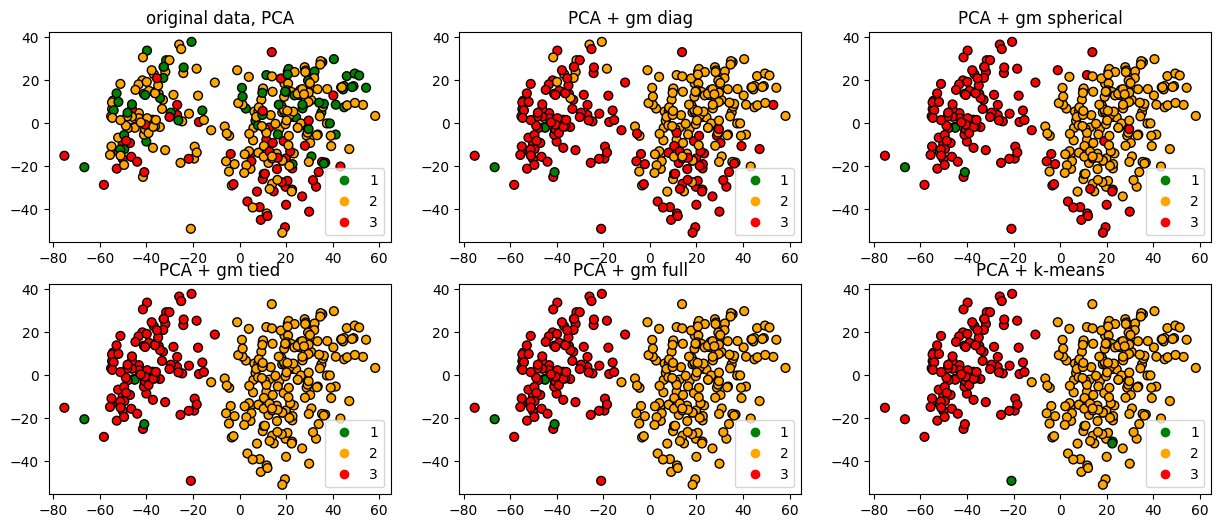

In [ ]:
plt.figure(figsize=(15, 6))

plt.subplot(2,3,1)
draw_plot_gm(X_pca, "PCA", original=True)

plt.subplot(2,3,2)
draw_plot_gm(X_pca, "PCA", original=False, covariance_type="diag")

plt.subplot(2,3,3)
draw_plot_gm(X_pca, "PCA", original=False, covariance_type="spherical")

plt.subplot(2,3,4)
draw_plot_gm(X_pca, "PCA", original=False, covariance_type="tied")

plt.subplot(2,3,5)
draw_plot_gm(X_pca, "PCA", original=False, covariance_type="full")

plt.subplot(2,3,6)
draw_plot_kmeans_new_rs(X_pca, "PCA")

### Relapse

In [ ]:
X = df_whole.drop(columns=["patient_id", "relapse"])

y = df_whole["relapse"]

X_scaled = scaler.fit_transform(X)

In [ ]:
# PCA to 2D
pca = PCA(n_components=140, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# run the tSNE algorithm
tsne = TSNE(n_components=3, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

#MDS
mds = MDS(n_components=200, random_state=42)
X_mds = mds.fit_transform(X_scaled)

/tmp/ipython-input-2017062710.py:43: UserWarning: Mismatched number of handles and labels: len(handles) = 2 len(labels) = 3
  plt.legend(handles=scatter.legend_elements()[0], labels=["1", "2", "3"])


GaussianMixture PCA, diag:
Davies–Bouldin index: 3.68, Silhouette score: 0.07, Simple Matching Coefficient: 0.53, Rand Index: 0.5
GaussianMixture PCA, spherical:
Davies–Bouldin index: 2.81, Silhouette score: 0.12, Simple Matching Coefficient: 0.56, Rand Index: 0.51
GaussianMixture PCA, tied:
Davies–Bouldin index: 2.45, Silhouette score: 0.15, Simple Matching Coefficient: 0.5, Rand Index: 0.5
GaussianMixture PCA, full:
Davies–Bouldin index: 2.45, Silhouette score: 0.15, Simple Matching Coefficient: 0.5, Rand Index: 0.5
k-means PCA:
Davies–Bouldin index: 2.45, Silhouette score: 0.15, Simple Matching Coefficient: 0.5, Rand Index: 0.5


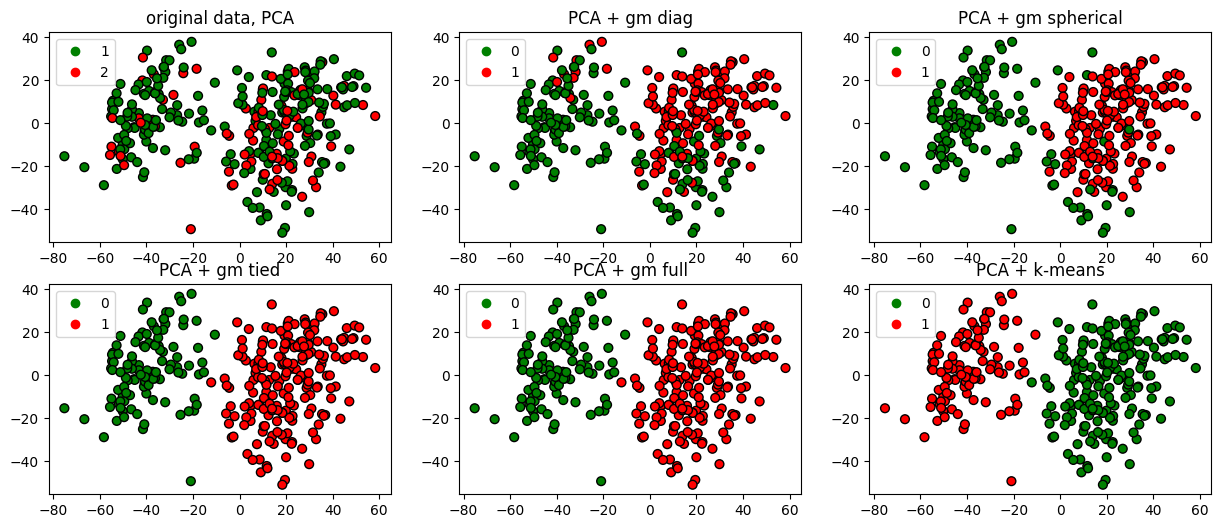

In [ ]:
plt.figure(figsize=(15, 6))

plt.subplot(2,3,1)
draw_plot_gm(X_pca, "PCA", original=True)

plt.subplot(2,3,2)
draw_plot_gm(X_pca, "PCA", original=False, covariance_type="diag")

plt.subplot(2,3,3)
draw_plot_gm(X_pca, "PCA", original=False, covariance_type="spherical")

plt.subplot(2,3,4)
draw_plot_gm(X_pca, "PCA", original=False, covariance_type="tied")

plt.subplot(2,3,5)
draw_plot_gm(X_pca, "PCA", original=False, covariance_type="full")

plt.subplot(2,3,6)
draw_plot_kmeans_new_rs(X_pca, "PCA", original=False)

### Node

In [ ]:
X = df_whole.drop(columns=["patient_id", "node"])

y = df_whole["node"]

X_scaled = scaler.fit_transform(X)

In [ ]:
# PCA to 2D
pca = PCA(n_components=140, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# run the tSNE algorithm
tsne = TSNE(n_components=3, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

#MDS
mds = MDS(n_components=200, random_state=42)
X_mds = mds.fit_transform(X_scaled)

/tmp/ipython-input-2017062710.py:43: UserWarning: Mismatched number of handles and labels: len(handles) = 2 len(labels) = 3
  plt.legend(handles=scatter.legend_elements()[0], labels=["1", "2", "3"])


GaussianMixture PCA, diag:
Davies–Bouldin index: 3.68, Silhouette score: 0.07, Simple Matching Coefficient: 0.55, Rand Index: 0.5
GaussianMixture PCA, spherical:
Davies–Bouldin index: 2.81, Silhouette score: 0.12, Simple Matching Coefficient: 0.54, Rand Index: 0.5
GaussianMixture PCA, tied:
Davies–Bouldin index: 2.45, Silhouette score: 0.15, Simple Matching Coefficient: 0.61, Rand Index: 0.52
GaussianMixture PCA, full:
Davies–Bouldin index: 2.45, Silhouette score: 0.15, Simple Matching Coefficient: 0.61, Rand Index: 0.52
k-means PCA:
Davies–Bouldin index: 2.45, Silhouette score: 0.15, Simple Matching Coefficient: 0.61, Rand Index: 0.52


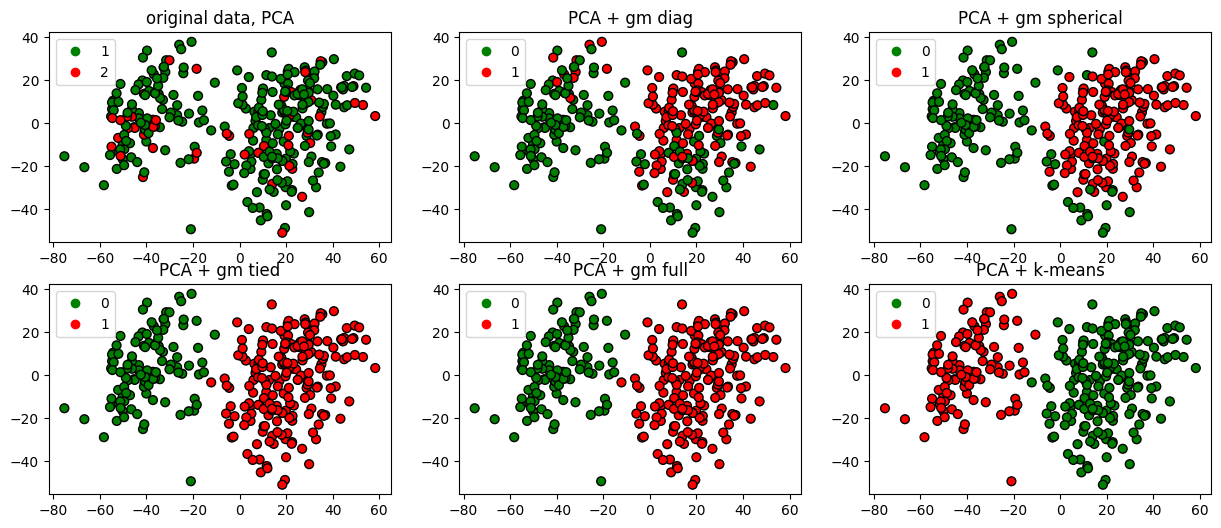

In [ ]:
plt.figure(figsize=(15, 6))

plt.subplot(2,3,1)
draw_plot_gm(X_pca, "PCA", original=True)

plt.subplot(2,3,2)
draw_plot_gm(X_pca, "PCA", original=False, covariance_type="diag")

plt.subplot(2,3,3)
draw_plot_gm(X_pca, "PCA", original=False, covariance_type="spherical")

plt.subplot(2,3,4)
draw_plot_gm(X_pca, "PCA", original=False, covariance_type="tied")

plt.subplot(2,3,5)
draw_plot_gm(X_pca, "PCA", original=False, covariance_type="full")

plt.subplot(2,3,6)
draw_plot_kmeans_new_rs(X_pca, "PCA", original=False)

In [ ]:
y_gm = GaussianMixture(n_components=2, covariance_type="tied", random_state=42).fit_predict(X_scaled)

cluster_summary = df_whole.copy()
cluster_summary['cluster'] = y_gm

summary = cluster_summary.groupby('cluster').mean()
print(summary)

         patient_id      node     grade      size        age       er  \
cluster                                                                 
0        159.288288  0.198198  1.963964  2.458559  61.375375  1.00000   
1        165.294118  0.161765  1.995098  2.089760  57.192810  0.77451   

          relapse      DDR1      RFC2     HSPA6  ...  CASP8AP2      POLM  \
cluster                                          ...                       
0        0.189189  9.110796  6.466700  5.413928  ...  6.167738  4.048364   
1        0.338235  9.405925  5.868247  6.302606  ...  6.421600  3.840098   

             KLK5    SH3BP4     SPO11      TRDN  DKFZP564C196     YDD19  \
cluster                                                                   
0        5.149436  8.504946  1.879069  0.009183      2.545605  3.506232   
1        5.485967  8.401541  2.932088  0.148346      2.004123  3.083017   

              TAZ     GMEB2  
cluster                      
0        5.370668  6.989969  
1        6.

# Part III — Prediction

Build and evaluate models for the different targets (relapse, er, size, grade, node):

You decide the pipelines (features → preprocessing → model).

Include at least two contrasting model families (e.g., linear vs. tree/ensemble vs. kernel).

Handle class imbalance appropriately (e.g., class weights, resampling within CV, threshold tuning).

## Catboost


### Er

In [ ]:
#splitting the data

X = df_whole.drop(columns=["patient_id", "er"])
y = df_whole["er"]

cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
train_pool = Pool(X_train, y_train, cat_features=cat_cols)
test_pool = Pool(X_test, y_test, cat_features=cat_cols)

model = CatBoostClassifier(
    iterations=100,      # number of trees
    learning_rate=0.1,    # step size
    loss_function='MultiClass' if len(y.unique())>2 else 'Logloss',
    eval_metric='TotalF1',  # work better than accuracy for imbalanced classes
    random_seed=42,
    verbose=False
)

model.fit(train_pool, eval_set=test_pool, early_stopping_rounds=50)

y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.9365079365079365
              precision    recall  f1-score   support

         0.0       1.00      0.56      0.71         9
         1.0       0.93      1.00      0.96        54

    accuracy                           0.94        63
   macro avg       0.97      0.78      0.84        63
weighted avg       0.94      0.94      0.93        63



In [ ]:
#=> does not work well due to the imbalance (recall 0.44). Also tried other metrics, worked even worse.

In [ ]:
#balancing the data

X = df_whole.drop(columns=["patient_id", "er"])
y = df_whole["er"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Apply SMOTE only on training data
smote = SMOTE(random_state=42)
X_train_os, y_train_os = smote.fit_resample(X_train, y_train)

print("Before:", y_train.value_counts())
print("After:", y_train_os.value_counts())

Before: er
1.0    215
0.0     37
Name: count, dtype: int64
After: er
1.0    215
0.0    215
Name: count, dtype: int64


In [ ]:
#a bit better =)

train_pool = Pool(X_train_os, y_train_os, cat_features=cat_cols)
test_pool = Pool(X_test, y_test, cat_features=cat_cols)

model = CatBoostClassifier(
    iterations=100,
    learning_rate=0.1,
    loss_function='MultiClass' if len(y.unique())>2 else 'Logloss',
    eval_metric='TotalF1',
    random_seed=42,
    verbose=False
)

model.fit(train_pool, eval_set=test_pool, early_stopping_rounds=50)

y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.9523809523809523
              precision    recall  f1-score   support

         0.0       0.88      0.78      0.82         9
         1.0       0.96      0.98      0.97        54

    accuracy                           0.95        63
   macro avg       0.92      0.88      0.90        63
weighted avg       0.95      0.95      0.95        63



In [ ]:
#lets try more iterations and lesser learning_rate

train_pool = Pool(X_train_os, y_train_os, cat_features=cat_cols)
test_pool = Pool(X_test, y_test, cat_features=cat_cols)

model = CatBoostClassifier(
    iterations=400,
    learning_rate=0.02,
    loss_function='MultiClass' if len(y.unique())>2 else 'Logloss',
    eval_metric='TotalF1',
    random_seed=42,
    verbose=False
)

model.fit(train_pool, eval_set=test_pool, early_stopping_rounds=50)

y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.9523809523809523
              precision    recall  f1-score   support

         0.0       0.88      0.78      0.82         9
         1.0       0.96      0.98      0.97        54

    accuracy                           0.95        63
   macro avg       0.92      0.88      0.90        63
weighted avg       0.95      0.95      0.95        63



Feature importance

In [ ]:
importances = model.get_feature_importance()
feat_imp = pd.Series(importances, index=X_train.columns)

feat_imp.sort_values(ascending=False).head(15)

ESR1      14.847003
ABL2       5.783015
PCTK2      5.117972
HMGCL      4.628919
ENSA       3.279260
PDE4A      2.638175
FGFR3      2.248277
DKC1       2.228812
BRAP       2.075616
IGF1R      1.777482
VPS33B     1.702536
PTK7       1.591778
DOC2B      1.587927
NPEPPS     1.574220
PIPOX      1.571635
dtype: float64

In [ ]:
#delete features with 0 importance
low_imp = feat_imp[feat_imp == 0].index

X_train_os = X_train_os.drop(columns=low_imp)
X_test = X_test.drop(columns=low_imp)

len(low_imp)

6301

In [ ]:
train_pool = Pool(X_train_os, y_train_os, cat_features=cat_cols)
test_pool = Pool(X_test, y_test, cat_features=cat_cols)

model = CatBoostClassifier(
    iterations=400,
    learning_rate=0.02,
    loss_function='MultiClass' if len(y.unique())>2 else 'Logloss',
    eval_metric='TotalF1',
    random_seed=42,
    verbose=False
)

model.fit(train_pool, eval_set=test_pool, early_stopping_rounds=50)

y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.9523809523809523
              precision    recall  f1-score   support

         0.0       0.88      0.78      0.82         9
         1.0       0.96      0.98      0.97        54

    accuracy                           0.95        63
   macro avg       0.92      0.88      0.90        63
weighted avg       0.95      0.95      0.95        63



Cutting more features out!

In [ ]:
low_imp = feat_imp[feat_imp < 0.2].index
len(low_imp)

6303

In [ ]:
X = df_whole.drop(columns=["patient_id", "er"])
y = df_whole["er"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

smote = SMOTE(random_state=42)
X_train_os, y_train_os = smote.fit_resample(X_train, y_train)

In [ ]:
X_train_os = X_train_os.drop(columns=low_imp)
X_test = X_test.drop(columns=low_imp)

train_pool = Pool(X_train_os, y_train_os, cat_features=cat_cols)
test_pool = Pool(X_test, y_test, cat_features=cat_cols)

model = CatBoostClassifier(
    iterations=400,
    learning_rate=0.006,
    loss_function='MultiClass' if len(y.unique())>2 else 'Logloss',
    eval_metric='TotalF1',
    random_seed=42,
    verbose=False
)

model.fit(train_pool, eval_set=test_pool, early_stopping_rounds=50)

y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.9523809523809523
              precision    recall  f1-score   support

         0.0       0.88      0.78      0.82         9
         1.0       0.96      0.98      0.97        54

    accuracy                           0.95        63
   macro avg       0.92      0.88      0.90        63
weighted avg       0.95      0.95      0.95        63



0.2 worked well, so wondering where the best cut is

In [ ]:
thresholds = np.arange(0.1, 2.2, 0.1)

for t in thresholds:
  print("THRESHOLD---------------", t)

  X = df_whole.drop(columns=["patient_id", "er"])
  y = df_whole["er"]

  X_train, X_test, y_train, y_test = train_test_split(
      X, y, test_size=0.2, random_state=42, stratify=y
  )

  smote = SMOTE(random_state=42)
  X_train_os, y_train_os = smote.fit_resample(X_train, y_train)

  low_imp = feat_imp[feat_imp < t].index

  X_train_os = X_train_os.drop(columns=low_imp)
  X_test = X_test.drop(columns=low_imp)

  train_pool = Pool(X_train_os, y_train_os, cat_features=cat_cols)
  test_pool = Pool(X_test, y_test, cat_features=cat_cols)

  model = CatBoostClassifier(
      iterations=1000,
      learning_rate=0.006,
      loss_function='MultiClass' if len(y.unique())>2 else 'Logloss',
      eval_metric='TotalF1',
      random_seed=42,
      verbose=False
  )

  model.fit(train_pool, eval_set=test_pool, early_stopping_rounds=50)

  y_pred = model.predict(X_test)
  print("Accuracy:", accuracy_score(y_test, y_pred))
  print(classification_report(y_test, y_pred))


THRESHOLD--------------- 0.1
Accuracy: 0.9682539682539683
              precision    recall  f1-score   support

         0.0       1.00      0.78      0.88         9
         1.0       0.96      1.00      0.98        54

    accuracy                           0.97        63
   macro avg       0.98      0.89      0.93        63
weighted avg       0.97      0.97      0.97        63

THRESHOLD--------------- 0.2
Accuracy: 0.9523809523809523
              precision    recall  f1-score   support

         0.0       0.88      0.78      0.82         9
         1.0       0.96      0.98      0.97        54

    accuracy                           0.95        63
   macro avg       0.92      0.88      0.90        63
weighted avg       0.95      0.95      0.95        63

THRESHOLD--------------- 0.30000000000000004
Accuracy: 0.9523809523809523
              precision    recall  f1-score   support

         0.0       0.88      0.78      0.82         9
         1.0       0.96      0.98      0.97    

=> will take a 2 threshold

In [ ]:
X = df_whole.drop(columns=["patient_id", "er"])
y = df_whole["er"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

smote = SMOTE(random_state=42)
X_train_os, y_train_os = smote.fit_resample(X_train, y_train)

In [ ]:
high_imp = feat_imp[feat_imp >= 2].index
print(len(high_imp))

9


In [ ]:
high_imp

Index(['DKC1', 'ENSA', 'HMGCL', 'FGFR3', 'PDE4A', 'ESR1', 'ABL2', 'PCTK2',
       'BRAP'],
      dtype='object')

=> final, optimized model with 9 features

In [ ]:
low_imp = feat_imp[feat_imp < 2].index

X_train_os = X_train_os.drop(columns=low_imp)
X_test = X_test.drop(columns=low_imp)

train_pool = Pool(X_train_os, y_train_os, cat_features=cat_cols)
test_pool = Pool(X_test, y_test, cat_features=cat_cols)

model = CatBoostClassifier(
    iterations=2000,
    learning_rate=0.0001,
    loss_function='MultiClass' if len(y.unique())>2 else 'Logloss',
    eval_metric='TotalF1',
    random_seed=42,
    verbose=False
)

model.fit(train_pool, eval_set=test_pool, early_stopping_rounds=50)

y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.9523809523809523
              precision    recall  f1-score   support

         0.0       0.88      0.78      0.82         9
         1.0       0.96      0.98      0.97        54

    accuracy                           0.95        63
   macro avg       0.92      0.88      0.90        63
weighted avg       0.95      0.95      0.95        63



In [ ]:
importances = model.get_feature_importance()
feat_imp = pd.Series(importances, index=X_train_os.columns)

feat_imp.sort_values(ascending=False)

PCTK2    20.572171
ENSA     14.774459
ABL2     14.438390
HMGCL    13.934806
ESR1     13.726124
PDE4A    11.312016
BRAP      8.603193
DKC1      2.121295
FGFR3     0.517545
dtype: float64

### Grade

Will go straight with resampling due to previous er experiments

In [ ]:
X = df_whole.drop(columns=["patient_id", "grade"])
y = df_whole["grade"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

smote = SMOTE(random_state=42)
X_train_os, y_train_os = smote.fit_resample(X_train, y_train)

Using smaller iterations and lr due to the large number of features and training time. Grade has more than 2 options, so the learning takes more time

In [ ]:
train_pool = Pool(X_train_os, y_train_os, cat_features=cat_cols)
test_pool = Pool(X_test, y_test, cat_features=cat_cols)

model = CatBoostClassifier(
    iterations=100,
    learning_rate=0.1,
    loss_function='MultiClass' if len(y.unique())>2 else 'Logloss',
    eval_metric='TotalF1',
    random_seed=42,
    verbose=False
)

model.fit(train_pool, eval_set=test_pool, early_stopping_rounds=50)

y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.6507936507936508
              precision    recall  f1-score   support

         1.0       0.50      0.50      0.50        14
         2.0       0.72      0.70      0.71        37
         3.0       0.62      0.67      0.64        12

    accuracy                           0.65        63
   macro avg       0.61      0.62      0.62        63
weighted avg       0.65      0.65      0.65        63



Lets see what happens with importances here

In [ ]:
importances = model.get_feature_importance()
feat_imp = pd.Series(importances, index=X_train.columns)

feat_imp.sort_values(ascending=False).head(15)

RAD51      2.613901
CX3CR1     2.538398
HN1        1.577140
C1orf21    1.454451
size       1.359720
node       1.268458
GABRA6     1.094050
HPSE       1.073633
MMP1       1.030943
BIRC5      1.029276
MYBL2      1.018304
CKS2       0.972988
SKP2       0.925767
MRPL12     0.921776
SLC24A1    0.862726
dtype: float64

In [ ]:
t = 0.1

low_imp = feat_imp[feat_imp < t].index
len(low_imp)

high_imp = feat_imp[feat_imp >= t].index
len(high_imp)

302

In [ ]:
t = 0.3

low_imp = feat_imp[feat_imp < t].index
len(low_imp)

high_imp = feat_imp[feat_imp >= t].index
len(high_imp)

93

In [ ]:
X = df_whole.drop(columns=["patient_id", "grade"])
y = df_whole["grade"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

smote = SMOTE(random_state=42)
X_train_os, y_train_os = smote.fit_resample(X_train, y_train)

low_imp = feat_imp[feat_imp < 0.5].index

X_train_os = X_train_os.drop(columns=low_imp)
X_test = X_test.drop(columns=low_imp)

train_pool = Pool(X_train_os, y_train_os, cat_features=cat_cols)
test_pool = Pool(X_test, y_test, cat_features=cat_cols)

model = CatBoostClassifier(
    iterations=200,
    learning_rate=0.006,
    loss_function='MultiClass' if len(y.unique())>2 else 'Logloss',
    eval_metric='TotalF1',
    random_seed=42,
    verbose=False
)

model.fit(train_pool, eval_set=test_pool, early_stopping_rounds=50)

y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.5873015873015873
              precision    recall  f1-score   support

         1.0       0.38      0.71      0.50        14
         2.0       0.90      0.49      0.63        37
         3.0       0.53      0.75      0.62        12

    accuracy                           0.59        63
   macro avg       0.60      0.65      0.58        63
weighted avg       0.71      0.59      0.60        63



In [ ]:
t = 0.9

low_imp = feat_imp[feat_imp < t].index
len(low_imp)

high_imp = feat_imp[feat_imp >= t].index
len(high_imp)

14

In [ ]:
thresholds = np.arange(0.3, 1, 0.1)

for t in thresholds:
  print("THRESHOLD---------------", t)

  X = df_whole.drop(columns=["patient_id", "grade"])
  y = df_whole["grade"]

  X_train, X_test, y_train, y_test = train_test_split(
      X, y, test_size=0.2, random_state=42, stratify=y
  )

  smote = SMOTE(random_state=42)
  X_train_os, y_train_os = smote.fit_resample(X_train, y_train)

  low_imp = feat_imp[feat_imp < t].index

  X_train_os = X_train_os.drop(columns=low_imp)
  X_test = X_test.drop(columns=low_imp)

  train_pool = Pool(X_train_os, y_train_os, cat_features=cat_cols)
  test_pool = Pool(X_test, y_test, cat_features=cat_cols)

  model = CatBoostClassifier(
      iterations=200,
      learning_rate=0.006,
      loss_function='MultiClass' if len(y.unique())>2 else 'Logloss',
      eval_metric='TotalF1',
      random_seed=42,
      verbose=False
  )

  model.fit(train_pool, eval_set=test_pool, early_stopping_rounds=50)

  y_pred = model.predict(X_test)
  print("Accuracy:", accuracy_score(y_test, y_pred))
  print(classification_report(y_test, y_pred))

THRESHOLD--------------- 0.3
Accuracy: 0.6349206349206349
              precision    recall  f1-score   support

         1.0       0.45      0.71      0.56        14
         2.0       0.88      0.57      0.69        37
         3.0       0.53      0.75      0.62        12

    accuracy                           0.63        63
   macro avg       0.62      0.68      0.62        63
weighted avg       0.72      0.63      0.65        63

THRESHOLD--------------- 0.4
Accuracy: 0.5714285714285714
              precision    recall  f1-score   support

         1.0       0.38      0.64      0.47        14
         2.0       0.78      0.49      0.60        37
         3.0       0.56      0.75      0.64        12

    accuracy                           0.57        63
   macro avg       0.57      0.63      0.57        63
weighted avg       0.65      0.57      0.58        63

THRESHOLD--------------- 0.5
Accuracy: 0.5873015873015873
              precision    recall  f1-score   support

         

**0.7** threshold is more balanced (the recalls are almost equal), so taking this one for the final model

In [ ]:
t = 0.7

X = df_whole.drop(columns=["patient_id", "grade"])
y = df_whole["grade"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

smote = SMOTE(random_state=42)
X_train_os, y_train_os = smote.fit_resample(X_train, y_train)

low_imp = feat_imp[feat_imp < t].index

X_train_os = X_train_os.drop(columns=low_imp)
X_test = X_test.drop(columns=low_imp)

train_pool = Pool(X_train_os, y_train_os, cat_features=cat_cols)
test_pool = Pool(X_test, y_test, cat_features=cat_cols)

model = CatBoostClassifier(
    iterations=800,
    learning_rate=0.0005,
    loss_function='MultiClass' if len(y.unique())>2 else 'Logloss',
    eval_metric='TotalF1',
    random_seed=42,
    verbose=False
)

model.fit(train_pool, eval_set=test_pool, early_stopping_rounds=50)

y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.6190476190476191
              precision    recall  f1-score   support

         1.0       0.45      0.93      0.60        14
         2.0       0.94      0.46      0.62        37
         3.0       0.56      0.75      0.64        12

    accuracy                           0.62        63
   macro avg       0.65      0.71      0.62        63
weighted avg       0.76      0.62      0.62        63



In [ ]:
high_imp = feat_imp[feat_imp >= 0.7].index
print(len(high_imp))

20


In [ ]:
high_imp

Index(['node', 'size', 'MYBL2', 'BIRC5', 'U2AF1', 'SLC25A12', 'SKP2', 'MRPL12',
       'CKS2', 'MMP1', 'TTK', 'RAD51', 'CX3CR1', 'SLC24A1', 'GABRA6', 'CDKN3',
       'HN1', 'KIF4A', 'HPSE', 'C1orf21'],
      dtype='object')

In [ ]:
importances = model.get_feature_importance()
feat_imp = pd.Series(importances, index=X_train_os.columns)

feat_imp.sort_values(ascending=False).head(15)

CX3CR1      26.002564
C1orf21     14.853277
KIAA0999     8.238621
node         5.023204
ZNF259       4.077076
size         3.463923
HSD17B7      2.874893
CLCN6        2.487662
CD44         2.157567
WARS         1.980302
C1R          1.937181
CD4          1.934997
CXADR        1.800154
S100A9       1.708523
MTF1         1.653575
dtype: float64

### Node

In [ ]:
X = df_whole.drop(columns=["patient_id", "node"])
y = df_whole["node"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

smote = SMOTE(random_state=42)
X_train_os, y_train_os = smote.fit_resample(X_train, y_train)

In [ ]:
print("Before:", y_train.value_counts())
print("After:", y_train_os.value_counts())

Before: node
0.0    208
1.0     44
Name: count, dtype: int64
After: node
1.0    208
0.0    208
Name: count, dtype: int64


In [ ]:
train_pool = Pool(X_train_os, y_train_os, cat_features=cat_cols)
test_pool = Pool(X_test, y_test, cat_features=cat_cols)

model = CatBoostClassifier(
    iterations=200,
    learning_rate=0.1,
    loss_function='MultiClass' if len(y.unique())>2 else 'Logloss',
    eval_metric='TotalF1',
    random_seed=42,
    verbose=False
)

model.fit(train_pool, eval_set=test_pool, early_stopping_rounds=50)

y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.8095238095238095
              precision    recall  f1-score   support

         0.0       0.87      0.90      0.89        52
         1.0       0.44      0.36      0.40        11

    accuracy                           0.81        63
   macro avg       0.66      0.63      0.64        63
weighted avg       0.80      0.81      0.80        63



Lets see what happens with importances here

In [ ]:
importances = model.get_feature_importance()
feat_imp = pd.Series(importances, index=X_train.columns)

feat_imp.sort_values(ascending=False).head(15)

grade       4.079467
size        3.654546
PARN        3.173319
KLRC3       3.145932
NFKBIA      2.280787
MTF1        2.148531
DIAPH1      2.091086
C1R         1.930884
NFAT5       1.877792
KIAA1539    1.868172
C1orf21     1.775693
CRH         1.677329
CRHBP       1.670058
CXADR       1.666513
ENSA        1.644026
dtype: float64

In [ ]:
t = 0.1

low_imp = feat_imp[feat_imp < t].index
len(low_imp)

high_imp = feat_imp[feat_imp >= t].index
len(high_imp)

116

In [ ]:
t = 0.3

low_imp = feat_imp[feat_imp < t].index
len(low_imp)

high_imp = feat_imp[feat_imp >= t].index
len(high_imp)

102

In [ ]:
t = 2

low_imp = feat_imp[feat_imp < t].index
len(low_imp)

high_imp = feat_imp[feat_imp >= t].index
len(high_imp)

7

In [ ]:
thresholds = np.arange(0.1, 2, 0.1)

for t in thresholds:
  print("THRESHOLD---------------", t)

  X = df_whole.drop(columns=["patient_id", "node"])
  y = df_whole["node"]

  X_train, X_test, y_train, y_test = train_test_split(
      X, y, test_size=0.2, random_state=42, stratify=y
  )

  smote = SMOTE(random_state=42)
  X_train_os, y_train_os = smote.fit_resample(X_train, y_train)

  low_imp = feat_imp[feat_imp < t].index

  X_train_os = X_train_os.drop(columns=low_imp)
  X_test = X_test.drop(columns=low_imp)

  train_pool = Pool(X_train_os, y_train_os, cat_features=cat_cols)
  test_pool = Pool(X_test, y_test, cat_features=cat_cols)

  model = CatBoostClassifier(
      iterations=200,
      learning_rate=0.006,
      loss_function='MultiClass' if len(y.unique())>2 else 'Logloss',
      eval_metric='TotalF1',
      random_seed=42,
      verbose=False
  )

  model.fit(train_pool, eval_set=test_pool, early_stopping_rounds=50)

  y_pred = model.predict(X_test)
  print("Accuracy:", accuracy_score(y_test, y_pred))
  print(classification_report(y_test, y_pred))

THRESHOLD--------------- 0.1
Accuracy: 0.873015873015873
              precision    recall  f1-score   support

         0.0       0.92      0.92      0.92        52
         1.0       0.64      0.64      0.64        11

    accuracy                           0.87        63
   macro avg       0.78      0.78      0.78        63
weighted avg       0.87      0.87      0.87        63

THRESHOLD--------------- 0.2
Accuracy: 0.873015873015873
              precision    recall  f1-score   support

         0.0       0.96      0.88      0.92        52
         1.0       0.60      0.82      0.69        11

    accuracy                           0.87        63
   macro avg       0.78      0.85      0.81        63
weighted avg       0.90      0.87      0.88        63

THRESHOLD--------------- 0.30000000000000004
Accuracy: 0.8571428571428571
              precision    recall  f1-score   support

         0.0       0.91      0.92      0.91        52
         1.0       0.60      0.55      0.57      

Trying even greater threasholds

In [ ]:
thresholds = np.arange(2, 10, 1)

for t in thresholds:
  print("THRESHOLD---------------", t)

  X = df_whole.drop(columns=["patient_id", "node"])
  y = df_whole["node"]

  X_train, X_test, y_train, y_test = train_test_split(
      X, y, test_size=0.2, random_state=42, stratify=y
  )

  smote = SMOTE(random_state=42)
  X_train_os, y_train_os = smote.fit_resample(X_train, y_train)

  low_imp = feat_imp[feat_imp < t].index

  X_train_os = X_train_os.drop(columns=low_imp)
  X_test = X_test.drop(columns=low_imp)

  train_pool = Pool(X_train_os, y_train_os, cat_features=cat_cols)
  test_pool = Pool(X_test, y_test, cat_features=cat_cols)

  model = CatBoostClassifier(
      iterations=200,
      learning_rate=0.006,
      loss_function='MultiClass' if len(y.unique())>2 else 'Logloss',
      eval_metric='TotalF1',
      random_seed=42,
      verbose=False
  )

  model.fit(train_pool, eval_set=test_pool, early_stopping_rounds=50)

  y_pred = model.predict(X_test)
  print("Accuracy:", accuracy_score(y_test, y_pred))
  print(classification_report(y_test, y_pred))

THRESHOLD--------------- 2
Accuracy: 0.7936507936507936
              precision    recall  f1-score   support

         0.0       0.98      0.77      0.86        52
         1.0       0.45      0.91      0.61        11

    accuracy                           0.79        63
   macro avg       0.72      0.84      0.73        63
weighted avg       0.88      0.79      0.82        63

THRESHOLD--------------- 3
Accuracy: 0.7936507936507936
              precision    recall  f1-score   support

         0.0       0.93      0.81      0.87        52
         1.0       0.44      0.73      0.55        11

    accuracy                           0.79        63
   macro avg       0.69      0.77      0.71        63
weighted avg       0.85      0.79      0.81        63

THRESHOLD--------------- 4
Accuracy: 0.6349206349206349
              precision    recall  f1-score   support

         0.0       1.00      0.56      0.72        52
         1.0       0.32      1.00      0.49        11

    accuracy  

CatBoostError: Input data must have at least one feature

The precision for class 1 is still too low

In [ ]:
t = 1.6

X = df_whole.drop(columns=["patient_id", "node"])
y = df_whole["node"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

smote = SMOTE(random_state=42)
X_train_os, y_train_os = smote.fit_resample(X_train, y_train)

low_imp = feat_imp[feat_imp < t].index

X_train_os = X_train_os.drop(columns=low_imp)
X_test = X_test.drop(columns=low_imp)

train_pool = Pool(X_train_os, y_train_os, cat_features=cat_cols)
test_pool = Pool(X_test, y_test, cat_features=cat_cols)

model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.0001,
    loss_function='MultiClass' if len(y.unique())>2 else 'Logloss',
    eval_metric='TotalF1',
    random_seed=42,
    verbose=False
)

model.fit(train_pool, eval_set=test_pool, early_stopping_rounds=50)

y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.9047619047619048
              precision    recall  f1-score   support

         0.0       0.91      0.98      0.94        52
         1.0       0.86      0.55      0.67        11

    accuracy                           0.90        63
   macro avg       0.88      0.76      0.81        63
weighted avg       0.90      0.90      0.90        63



In [ ]:
high_imp = feat_imp[feat_imp >= 1.6].index
print(len(high_imp))

20


In [ ]:
high_imp

Index(['grade', 'size', 'relapse', 'TRADD', 'NBL1', 'CTCF', 'MAP1A', 'ICA1',
       'CD44', 'HHEX', 'RAMP1', 'RAD51', 'SPINK5', 'INPP4B', 'AKAP5', 'RPS3',
       'CETN2', 'PIK3CB', 'AREG', 'SAMSN1'],
      dtype='object')

In [ ]:
importances = model.get_feature_importance()
feat_imp = pd.Series(importances, index=X_train_os.columns)

feat_imp.sort_values(ascending=False).head(15)

AREG      10.534550
PIK3CB     4.140364
CTCF       3.603715
ICA1       3.307661
grade      3.219883
CD44       2.992680
size       2.862265
INPP4B     2.857388
CETN2      2.554600
TRADD      2.125991
RAMP1      2.076627
HHEX       1.942321
NBL1       1.866582
MAP1A      1.750698
SAMSN1     1.734976
dtype: float64

### Relapse

In [ ]:
X = df_whole.drop(columns=["patient_id", "relapse"])
y = df_whole["relapse"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

smote = SMOTE(random_state=42)
X_train_os, y_train_os = smote.fit_resample(X_train, y_train)

In [ ]:
print("Before:", y_train.value_counts())
print("After:", y_train_os.value_counts())

Before: relapse
0.0    180
1.0     72
Name: count, dtype: int64
After: relapse
1.0    180
0.0    180
Name: count, dtype: int64


In [ ]:
train_pool = Pool(X_train_os, y_train_os, cat_features=cat_cols)
test_pool = Pool(X_test, y_test, cat_features=cat_cols)

model = CatBoostClassifier(
    iterations=200,
    learning_rate=0.1,
    loss_function='MultiClass' if len(y.unique())>2 else 'Logloss',
    eval_metric='TotalF1',
    random_seed=42,
    verbose=False
)

model.fit(train_pool, eval_set=test_pool, early_stopping_rounds=50)

y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.746031746031746
              precision    recall  f1-score   support

         0.0       0.76      0.93      0.84        45
         1.0       0.62      0.28      0.38        18

    accuracy                           0.75        63
   macro avg       0.69      0.61      0.61        63
weighted avg       0.72      0.75      0.71        63



Lets see what happens with importances here

In [ ]:
importances = model.get_feature_importance()
feat_imp = pd.Series(importances, index=X_train.columns)

feat_imp.sort_values(ascending=False).head(15)

SERPINB2    3.551215
RALA        2.984496
LAMP1       2.891719
CCNI        2.858947
ALDH3A1     2.699513
IGFBP5      2.478275
NPAT        2.449625
GJB3        2.215925
IFRD1       1.879385
MVP         1.859281
MMP8        1.848407
VPS41       1.767055
TADA2L      1.706754
NRG1        1.655757
B3GAT3      1.602851
dtype: float64

In [ ]:
t = 1

low_imp = feat_imp[feat_imp < t].index
len(low_imp)

high_imp = feat_imp[feat_imp >= t].index
len(high_imp)

44

In [ ]:
t = 0.3

low_imp = feat_imp[feat_imp < t].index
len(low_imp)

high_imp = feat_imp[feat_imp >= t].index
len(high_imp)

91

In [ ]:
thresholds = np.arange(0.2, 2, 0.2)

for t in thresholds:
  print("THRESHOLD---------------", t)

  X = df_whole.drop(columns=["patient_id", "relapse"])
  y = df_whole["relapse"]

  X_train, X_test, y_train, y_test = train_test_split(
      X, y, test_size=0.2, random_state=42, stratify=y
  )

  smote = SMOTE(random_state=42)
  X_train_os, y_train_os = smote.fit_resample(X_train, y_train)

  low_imp = feat_imp[feat_imp < t].index

  X_train_os = X_train_os.drop(columns=low_imp)
  X_test = X_test.drop(columns=low_imp)

  train_pool = Pool(X_train_os, y_train_os, cat_features=cat_cols)
  test_pool = Pool(X_test, y_test, cat_features=cat_cols)

  model = CatBoostClassifier(
      iterations=200,
      learning_rate=0.006,
      loss_function='MultiClass' if len(y.unique())>2 else 'Logloss',
      eval_metric='TotalF1',
      random_seed=42,
      verbose=False
  )

  model.fit(train_pool, eval_set=test_pool, early_stopping_rounds=50)

  y_pred = model.predict(X_test)
  print("Accuracy:", accuracy_score(y_test, y_pred))
  print(classification_report(y_test, y_pred))

THRESHOLD--------------- 0.2
Accuracy: 0.7301587301587301
              precision    recall  f1-score   support

         0.0       0.79      0.84      0.82        45
         1.0       0.53      0.44      0.48        18

    accuracy                           0.73        63
   macro avg       0.66      0.64      0.65        63
weighted avg       0.72      0.73      0.72        63

THRESHOLD--------------- 0.4
Accuracy: 0.6984126984126984
              precision    recall  f1-score   support

         0.0       0.75      0.87      0.80        45
         1.0       0.45      0.28      0.34        18

    accuracy                           0.70        63
   macro avg       0.60      0.57      0.57        63
weighted avg       0.67      0.70      0.67        63

THRESHOLD--------------- 0.6000000000000001
Accuracy: 0.6666666666666666
              precision    recall  f1-score   support

         0.0       0.75      0.80      0.77        45
         1.0       0.40      0.33      0.36     

In [ ]:
t = 0.2

X = df_whole.drop(columns=["patient_id", "relapse"])
y = df_whole["relapse"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

smote = SMOTE(random_state=42)
X_train_os, y_train_os = smote.fit_resample(X_train, y_train)

low_imp = feat_imp[feat_imp < t].index

X_train_os = X_train_os.drop(columns=low_imp)
X_test = X_test.drop(columns=low_imp)

train_pool = Pool(X_train_os, y_train_os, cat_features=cat_cols)
test_pool = Pool(X_test, y_test, cat_features=cat_cols)

model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.0001,
    loss_function='MultiClass' if len(y.unique())>2 else 'Logloss',
    eval_metric='TotalF1',
    random_seed=42,
    verbose=False
)

model.fit(train_pool, eval_set=test_pool, early_stopping_rounds=50)

y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.7301587301587301
              precision    recall  f1-score   support

         0.0       0.79      0.84      0.82        45
         1.0       0.53      0.44      0.48        18

    accuracy                           0.73        63
   macro avg       0.66      0.64      0.65        63
weighted avg       0.72      0.73      0.72        63



In [ ]:
high_imp = feat_imp[feat_imp >= 0.2].index
print(len(high_imp))

96


In [ ]:
high_imp

Index(['RPS24', 'AP2M1', 'CLTC', 'WARS', 'ACADVL', 'CCT7', 'TACC1', 'RAF1',
       'DKC1', 'TSN', 'LAMP1', 'ADNP', 'KIAA0494', 'ACAA1', 'IFRD1', 'MVP',
       'MAP2K2', 'GNAQ', 'EFNB1', 'PDCD4', 'HCLS1', 'IMPA1', 'UROS', 'VPS41',
       'IGFBP5', 'B3GAT3', 'LSM1', 'CD163', 'ITPR1', 'ERCC1', 'WWP2', 'SCG2',
       'CD37', 'SERPINB2', 'RAD51', 'GLI3', 'PARD6A', 'ZNF174', 'GJB3', 'ETV6',
       'ALDH3A1', 'SH3GL3', 'MMP3', 'PTX3', 'NRG1', 'PTAFR', 'PDK3', 'MYOD1',
       'SP4', 'FKBP6', 'ZNF124', 'SLC30A3', 'CDKN2A', 'ZNF223', 'ADCYAP1R1',
       'SIGLEC7', 'MMP8', 'MPL', 'TCL6', 'MCF2', 'ZNF157', 'ITGB6', 'DUX1',
       'RASGRP2', 'DRD4', 'GAGE1', 'ABCB11', 'UGT8', 'HPR', 'LMX1B', 'MTNR1B',
       'CCNI', 'PTRF', 'UROD', 'LMO4', 'PCYT2', 'PLD2', 'MYCN', 'NPAT',
       'TADA2L', 'EFNA3', 'NR5A1', 'CAMK4', 'GRB7', 'UBE3A', 'STX10', 'PMS1',
       'RALA', 'SLC5A4', 'ITM2B', 'NIT2', 'EHD3', 'USP25', 'CRTAC1', 'C1orf21',
       'ADAM30'],
      dtype='object')

In [ ]:
importances = model.get_feature_importance()
feat_imp = pd.Series(importances, index=X_train_os.columns)

feat_imp.sort_values(ascending=False).head(15)

SERPINB2     12.019244
ZNF174        8.897566
RALA          7.766310
ITM2B         6.044517
RAD51         4.569702
NPAT          4.037141
ADCYAP1R1     3.514456
CCNI          3.057814
MVP           2.943210
ALDH3A1       2.937631
PDK3          2.582139
RASGRP2       2.562435
TACC1         2.240690
VPS41         2.000114
NRG1          1.967236
dtype: float64

### Size

In [ ]:
y = df_whole["size"]
X = df_whole.drop(columns=["patient_id", "size"])

# drop rows with missing target
mask = y.notna()
X, y = X.loc[mask], y.loc[mask]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

train_pool = Pool(X_train, y_train)
test_pool = Pool(X_test, y_test)

model = CatBoostRegressor(
    iterations=100,
    learning_rate=0.05,
    depth=6,
    loss_function="MAE",
    eval_metric="MAE",
    random_seed=42,
    verbose=False
)

model.fit(
    train_pool,
    eval_set=test_pool,
    early_stopping_rounds=50
)


In [ ]:
y_pred = model.predict(X_test)

print("R2:", round(r2_score(y_test, y_pred), 3))
print("MAE:", round(mean_absolute_error(y_test, y_pred), 3))
print("RMSE:", round(mean_squared_error(y_test, y_pred), 3))

R2: 0.01
MAE: 0.74
RMSE: 1.095


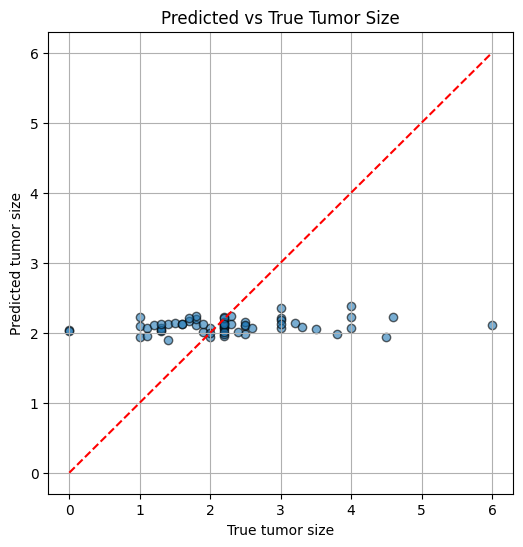

In [ ]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6, edgecolor="k")
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         "r--")
plt.xlabel("True tumor size")
plt.ylabel("Predicted tumor size")
plt.title("Predicted vs True Tumor Size")
plt.grid(True)
plt.show()


In [ ]:
imp = model.get_feature_importance()
feat_imp = (
    pd.Series(imp, index=X.columns)
    .sort_values(ascending=False)
)

feat_imp.head(15)

NCAM1      2.677290
DUSP3      2.432831
IGFBP6     2.351558
HSPC159    2.327998
UBE2L3     2.177345
SS18       2.080513
PRKY       2.066156
SFTPC      2.060796
LDLR       1.682653
DFFB       1.636561
IL2RB      1.632276
UBQLN3     1.617236
CTSE       1.601868
MMD        1.589487
RFPL1      1.516020
dtype: float64

In [ ]:
thresholds = np.arange(0.1, 2, 0.1)

for t in thresholds:
  print("THRESHOLD---------------", t)

  X = df_whole.drop(columns=["patient_id", "size"])
  y = df_whole["size"]

  X_train, X_test, y_train, y_test = train_test_split(
      X, y, test_size=0.2, random_state=42
  )


  low_imp = feat_imp[feat_imp < t].index

  X_train = X_train.drop(columns=low_imp)
  X_test = X_test.drop(columns=low_imp)

  train_pool = Pool(X_train, y_train)
  test_pool = Pool(X_test, y_test)


  model = CatBoostRegressor(
      iterations=1000,
      learning_rate=0.005,
      depth=6,
      loss_function="MAE",
      eval_metric="MAE",
      random_seed=42,
      verbose=False
  )

  model.fit(
      train_pool,
      eval_set=test_pool,
      early_stopping_rounds=50
  )

  y_pred = model.predict(X_test)

  print("R2:", round(r2_score(y_test, y_pred), 3))
  print("MAE:", round(mean_absolute_error(y_test, y_pred), 3))
  print("RMSE:", round(mean_squared_error(y_test, y_pred), 3))


THRESHOLD--------------- 0.1
R2: 0.036
MAE: 0.725
RMSE: 1.067
THRESHOLD--------------- 0.2
R2: 0.012
MAE: 0.736
RMSE: 1.093
THRESHOLD--------------- 0.30000000000000004
R2: 0.022
MAE: 0.728
RMSE: 1.083
THRESHOLD--------------- 0.4
R2: 0.01
MAE: 0.736
RMSE: 1.096
THRESHOLD--------------- 0.5
R2: 0.016
MAE: 0.732
RMSE: 1.089
THRESHOLD--------------- 0.6
R2: 0.026
MAE: 0.725
RMSE: 1.078
THRESHOLD--------------- 0.7000000000000001
R2: 0.02
MAE: 0.733
RMSE: 1.084
THRESHOLD--------------- 0.8
R2: 0.023
MAE: 0.726
RMSE: 1.081
THRESHOLD--------------- 0.9
R2: 0.017
MAE: 0.728
RMSE: 1.088
THRESHOLD--------------- 1.0
R2: 0.021
MAE: 0.726
RMSE: 1.084
THRESHOLD--------------- 1.1
R2: 0.035
MAE: 0.724
RMSE: 1.068
THRESHOLD--------------- 1.2000000000000002
R2: 0.039
MAE: 0.724
RMSE: 1.063
THRESHOLD--------------- 1.3000000000000003
R2: 0.03
MAE: 0.725
RMSE: 1.073
THRESHOLD--------------- 1.4000000000000001
R2: 0.033
MAE: 0.724
RMSE: 1.07
THRESHOLD--------------- 1.5000000000000002
R2: 0.032
MAE: 0

R2: 0.039
MAE: 0.724
RMSE: 1.063


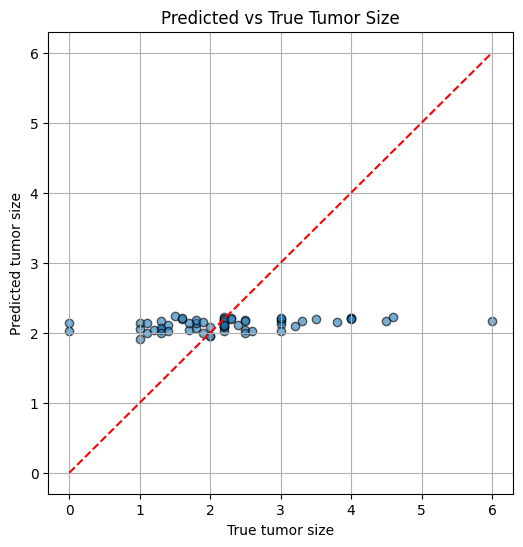

In [ ]:
  t=1.2

  X = df_whole.drop(columns=["patient_id", "size"])
  y = df_whole["size"]

  X_train, X_test, y_train, y_test = train_test_split(
      X, y, test_size=0.2, random_state=42
  )


  low_imp = feat_imp[feat_imp < t].index

  X_train = X_train.drop(columns=low_imp)
  X_test = X_test.drop(columns=low_imp)

  train_pool = Pool(X_train, y_train)
  test_pool = Pool(X_test, y_test)


  model = CatBoostRegressor(
      iterations=1000,
      learning_rate=0.005,
      depth=6,
      loss_function="MAE",
      eval_metric="MAE",
      random_seed=42,
      verbose=False
  )

  model.fit(
      train_pool,
      eval_set=test_pool,
      early_stopping_rounds=50
  )

  y_pred = model.predict(X_test)

  print("R2:", round(r2_score(y_test, y_pred), 3))
  print("MAE:", round(mean_absolute_error(y_test, y_pred), 3))
  print("RMSE:", round(mean_squared_error(y_test, y_pred), 3))


plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6, edgecolor="k")
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         "r--")
plt.xlabel("True tumor size")
plt.ylabel("Predicted tumor size")
plt.title("Predicted vs True Tumor Size")
plt.grid(True)
plt.show()


Trying log stransform

In [ ]:
y = df_whole["size"]
y = np.log1p(y) #trying to reduce the bias towards large tumors
X = df_whole.drop(columns=["patient_id", "size"])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

train_pool = Pool(X_train, y_train)
test_pool = Pool(X_test, y_test)

model = CatBoostRegressor(
    iterations=100,
    learning_rate=0.05,
    depth=6,
    loss_function="MAE",
    eval_metric="MAE",
    random_seed=42,
    verbose=False
)

model.fit(
    train_pool,
    eval_set=test_pool,
    early_stopping_rounds=50
)

In [ ]:
y_pred = model.predict(X_test)

y_pred = np.expm1(y_pred)
y_test = np.expm1(y_test)

print("R2:", round(r2_score(y_test, y_pred), 3))
print("MAE:", round(mean_absolute_error(y_test, y_pred), 3))
print("RMSE:", round(mean_squared_error(y_test, y_pred), 3))

R2: -0.0
MAE: 0.743
RMSE: 1.107


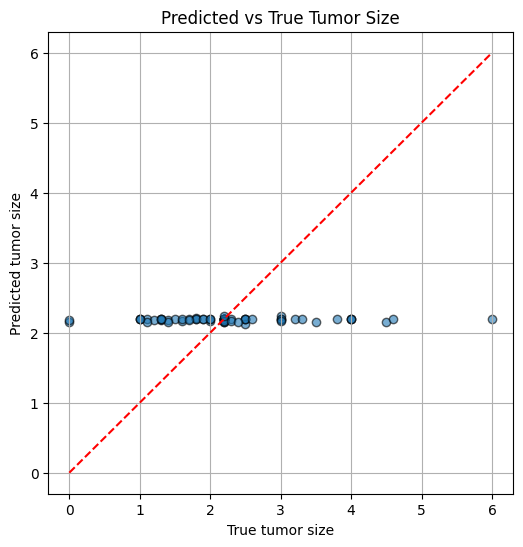

In [ ]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6, edgecolor="k")
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         "r--")
plt.xlabel("True tumor size")
plt.ylabel("Predicted tumor size")
plt.title("Predicted vs True Tumor Size")
plt.grid(True)
plt.show()


## Logistic Regression

### Er

In [ ]:
X = df_whole.drop(columns=["patient_id", "er"])
y = df_whole["er"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()

scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)


model = LogisticRegression(
    max_iter=1000, #tried different options
    class_weight="balanced",  # for imbalance
    random_state=42
)

model.fit(X_train_sc, y_train)

y_pred = model.predict(X_test_sc)
y_proba = model.predict_proba(X_test_sc)[:, 1]


print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

              precision    recall  f1-score   support

         0.0       1.00      0.67      0.80         9
         1.0       0.95      1.00      0.97        54

    accuracy                           0.95        63
   macro avg       0.97      0.83      0.89        63
weighted avg       0.95      0.95      0.95        63

ROC AUC: 0.9423868312757202


In [ ]:
X = df_whole.drop(columns=["patient_id", "er"])
y = df_whole["er"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)


model = LogisticRegression(
    max_iter=2000,
    class_weight="balanced",  # for imbalance
    random_state=42
)

model.fit(X_train_sc, y_train)

y_pred = model.predict(X_test_sc)
y_proba = model.predict_proba(X_test_sc)[:, 1]


print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

              precision    recall  f1-score   support

         0.0       1.00      0.67      0.80         9
         1.0       0.95      1.00      0.97        54

    accuracy                           0.95        63
   macro avg       0.97      0.83      0.89        63
weighted avg       0.95      0.95      0.95        63

ROC AUC: 0.9423868312757202


In [ ]:
y_proba.min(), y_proba.max()

(np.float64(0.0030994766524803843), np.float64(0.9999998113227714))

In [ ]:

thresholds = np.linspace(0.05, 0.5, 50)
f1s = [f1_score(y_test, (y_proba > t).astype(int)) for t in thresholds]

best_t = thresholds[np.argmax(f1s)]
best_t

np.float64(0.27040816326530615)

In [ ]:
y_pred_adj = (y_proba > 0.27).astype(int)

print(classification_report(y_test, y_pred_adj))

              precision    recall  f1-score   support

         0.0       1.00      0.67      0.80         9
         1.0       0.95      1.00      0.97        54

    accuracy                           0.95        63
   macro avg       0.97      0.83      0.89        63
weighted avg       0.95      0.95      0.95        63



In [ ]:
model = LogisticRegression(
    max_iter=50000,
    class_weight="balanced",  # for imbalance
    penalty="l1", #similar to feature selection
    solver="saga",
    random_state=42
)

model.fit(X_train_sc, y_train)

y_pred = model.predict(X_test_sc)
y_proba = model.predict_proba(X_test_sc)[:, 1]


print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

              precision    recall  f1-score   support

         0.0       0.62      0.56      0.59         9
         1.0       0.93      0.94      0.94        54

    accuracy                           0.89        63
   macro avg       0.78      0.75      0.76        63
weighted avg       0.88      0.89      0.89        63

ROC AUC: 0.9218106995884774


In [ ]:
feature_importance = pd.DataFrame({
    "feature": X_train.columns,
    "coef": model.coef_[0]
})

feature_importance["abs_coef"] = feature_importance["coef"].abs()
feature_importance.sort_values(
    by="abs_coef", ascending=False
).head(20)

feature      coef  abs_coef
1        grade -0.417087  0.417087
1533  KIAA0020 -0.376158  0.376158
4717      TSHR  0.317498  0.317498
1484   SULT1A1  0.310738  0.310738
2321      ESR1  0.305003  0.305003
3950       IL5 -0.272861  0.272861
1592    MAPRE3  0.223444  0.223444
226      RPL23 -0.221489  0.221489
4292  EIF4EBP2 -0.219720  0.219720
2119     MTERF  0.214064  0.214064
2961      FMO4 -0.212554  0.212554
1963     ABCG1  0.196978  0.196978
174       ECH1  0.192643  0.192643
2991     CRLF1  0.190757  0.190757
3934       ZFX  0.177409  0.177409
5175    RANBP6 -0.175936  0.175936
5413    PIWIL1  0.174687  0.174687
1668      FUT8  0.160971  0.160971
3726   C6orf10  0.152458  0.152458
160     NFE2L1  0.151602  0.151602

### Node

In [ ]:
X = df_whole.drop(columns=["patient_id", "node"])
y = df_whole["node"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)


model = LogisticRegression(
    max_iter=2000,
    class_weight="balanced",  # for imbalance
    random_state=42
)

model.fit(X_train_sc, y_train)

y_pred = model.predict(X_test_sc)
y_proba = model.predict_proba(X_test_sc)[:, 1]


print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

              precision    recall  f1-score   support

         0.0       0.84      0.98      0.90        52
         1.0       0.50      0.09      0.15        11

    accuracy                           0.83        63
   macro avg       0.67      0.54      0.53        63
weighted avg       0.78      0.83      0.77        63

ROC AUC: 0.7237762237762237


In [ ]:
y_proba.min(), y_proba.max()

(np.float64(2.8540110779778165e-06), np.float64(0.566506711433278))

In [ ]:
import numpy as np
from sklearn.metrics import f1_score

thresholds = np.linspace(0.05, 0.5, 50)
f1s = [f1_score(y_test, (y_proba > t).astype(int)) for t in thresholds]

best_t = thresholds[np.argmax(f1s)]
best_t

np.float64(0.05)

In [ ]:
thresholds = np.linspace(0.05, 0.5, 50)
f1s = [roc_auc_score(y_test, (y_proba > t).astype(int)) for t in thresholds]

best_t = thresholds[np.argmax(f1s)]
best_t

np.float64(0.05)

In [ ]:
y_pred_adj = (y_proba > 0.05).astype(int)

print(classification_report(y_test, y_pred_adj))

              precision    recall  f1-score   support

         0.0       0.88      0.87      0.87        52
         1.0       0.42      0.45      0.43        11

    accuracy                           0.79        63
   macro avg       0.65      0.66      0.65        63
weighted avg       0.80      0.79      0.80        63



In [ ]:

model = LogisticRegression(
    max_iter=10000,
    class_weight="balanced",  # for imbalance
    random_state=42,
    penalty="l1", #similar to feature selection
    solver="saga",
)

model.fit(X_train_sc, y_train)

y_pred = model.predict(X_test_sc)
y_proba = model.predict_proba(X_test_sc)[:, 1]


print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

              precision    recall  f1-score   support

         0.0       0.86      0.92      0.89        52
         1.0       0.43      0.27      0.33        11

    accuracy                           0.81        63
   macro avg       0.64      0.60      0.61        63
weighted avg       0.78      0.81      0.79        63

ROC AUC: 0.7972027972027972


In [ ]:
thresholds = np.linspace(0.05, 0.5, 50)
f1s = [roc_auc_score(y_test, (y_proba > t).astype(int)) for t in thresholds]

best_t = thresholds[np.argmax(f1s)]
best_t

np.float64(0.1326530612244898)

In [ ]:
y_pred_adj = (y_proba > 0.13).astype(int)

print(classification_report(y_test, y_pred_adj))

              precision    recall  f1-score   support

         0.0       0.97      0.73      0.84        52
         1.0       0.42      0.91      0.57        11

    accuracy                           0.76        63
   macro avg       0.70      0.82      0.70        63
weighted avg       0.88      0.76      0.79        63



Smote

In [ ]:
smote = SMOTE(random_state=42)
X_train_os, y_train_os = smote.fit_resample(X_train_sc, y_train)

model = LogisticRegression(
    max_iter=10000,
    class_weight="balanced",  # for imbalance
    random_state=42,
    penalty="l1", #similar to feature selection
    solver="saga",
)

model.fit(X_train_os, y_train_os)

y_pred = model.predict(X_test_sc)
y_proba = model.predict_proba(X_test_sc)[:, 1]


print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

              precision    recall  f1-score   support

         0.0       0.83      0.94      0.88        52
         1.0       0.25      0.09      0.13        11

    accuracy                           0.79        63
   macro avg       0.54      0.52      0.51        63
weighted avg       0.73      0.79      0.75        63

ROC AUC: 0.7972027972027972


In [ ]:
thresholds = np.linspace(0.05, 0.5, 50)
f1s = [roc_auc_score(y_test, (y_proba > t).astype(int)) for t in thresholds]

best_t = thresholds[np.argmax(f1s)]
best_t

np.float64(0.07755102040816328)

In [ ]:
y_pred_adj = (y_proba > 0.077).astype(int)

print(classification_report(y_test, y_pred_adj))

              precision    recall  f1-score   support

         0.0       0.97      0.69      0.81        52
         1.0       0.38      0.91      0.54        11

    accuracy                           0.73        63
   macro avg       0.68      0.80      0.67        63
weighted avg       0.87      0.73      0.76        63



### Relapse

In [ ]:
X = df_whole.drop(columns=["patient_id", "relapse"])
y = df_whole["relapse"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)


model = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",  # for imbalance
    random_state=42
)

model.fit(X_train_sc, y_train)

y_pred = model.predict(X_test_sc)
y_proba = model.predict_proba(X_test_sc)[:, 1]


print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

              precision    recall  f1-score   support

         0.0       0.75      0.89      0.82        45
         1.0       0.50      0.28      0.36        18

    accuracy                           0.71        63
   macro avg       0.63      0.58      0.59        63
weighted avg       0.68      0.71      0.69        63

ROC AUC: 0.5814814814814815


In [ ]:
thresholds = np.linspace(0.001, 0.5, 100)
f1s = [roc_auc_score(y_test, (y_proba > t).astype(int)) for t in thresholds]

best_t = thresholds[np.argmax(f1s)]
best_t

np.float64(0.06148484848484849)

In [ ]:
y_pred_adj = (y_proba > 0.06).astype(int)

print(classification_report(y_test, y_pred_adj))

              precision    recall  f1-score   support

         0.0       0.75      0.67      0.71        45
         1.0       0.35      0.44      0.39        18

    accuracy                           0.60        63
   macro avg       0.55      0.56      0.55        63
weighted avg       0.64      0.60      0.62        63



In [ ]:
model = LogisticRegression(
    penalty="l2",
    C=0.1,                 # сильнее регуляризация
    class_weight="balanced",
    max_iter=2000,
    random_state=42
)

model.fit(X_train_sc, y_train)

y_pred = model.predict(X_test_sc)
y_proba = model.predict_proba(X_test_sc)[:, 1]


print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

              precision    recall  f1-score   support

         0.0       0.75      0.89      0.82        45
         1.0       0.50      0.28      0.36        18

    accuracy                           0.71        63
   macro avg       0.63      0.58      0.59        63
weighted avg       0.68      0.71      0.69        63

ROC AUC: 0.5790123456790124


In [ ]:
thresholds = np.linspace(0.001, 0.5, 100)
f1s = [roc_auc_score(y_test, (y_proba > t).astype(int)) for t in thresholds]

best_t = thresholds[np.argmax(f1s)]
best_t

np.float64(0.16733333333333333)

In [ ]:
y_pred_adj = (y_proba > 0.16).astype(int)

print(classification_report(y_test, y_pred_adj))

              precision    recall  f1-score   support

         0.0       0.76      0.69      0.72        45
         1.0       0.36      0.44      0.40        18

    accuracy                           0.62        63
   macro avg       0.56      0.57      0.56        63
weighted avg       0.64      0.62      0.63        63



In [ ]:
model = LogisticRegression(
    penalty="l1",
    solver="saga",
    class_weight="balanced",
    random_state=42
)

model.fit(X_train_sc, y_train)

y_pred = model.predict(X_test_sc)
y_proba = model.predict_proba(X_test_sc)[:, 1]


print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

              precision    recall  f1-score   support

         0.0       0.73      0.67      0.70        45
         1.0       0.32      0.39      0.35        18

    accuracy                           0.59        63
   macro avg       0.52      0.53      0.52        63
weighted avg       0.61      0.59      0.60        63

ROC AUC: 0.608641975308642


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [ ]:
thresholds = np.linspace(0.001, 0.5, 100)
f1s = [roc_auc_score(y_test, (y_proba > t).astype(int)) for t in thresholds]

best_t = thresholds[np.argmax(f1s)]
best_t

np.float64(0.43447474747474746)

In [ ]:
y_pred_adj = (y_proba > 0.43).astype(int)

print(classification_report(y_test, y_pred_adj))

              precision    recall  f1-score   support

         0.0       0.74      0.82      0.78        45
         1.0       0.38      0.28      0.32        18

    accuracy                           0.67        63
   macro avg       0.56      0.55      0.55        63
weighted avg       0.64      0.67      0.65        63



Feature importance?

### Grade

In [ ]:
X = df_whole.drop(columns=["patient_id", "grade"])
y = df_whole["grade"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

In [ ]:

model = LogisticRegression(
    max_iter=3000,
    class_weight="balanced",
    random_state=42
)

model.fit(X_train_sc, y_train)

y_pred = model.predict(X_test_sc)
y_proba = model.predict_proba(X_test_sc)[:, 1]

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

         1.0       0.55      0.43      0.48        14
         2.0       0.70      0.81      0.75        37
         3.0       0.56      0.42      0.48        12

    accuracy                           0.65        63
   macro avg       0.60      0.55      0.57        63
weighted avg       0.64      0.65      0.64        63



Feature importance?

In [ ]:
coef = model.coef_[0]

global_imp = pd.Series(coef, index=X.columns).abs()
global_imp = global_imp.sort_values(ascending=False)

global_imp.head(15)

node        0.043420
GABRA6      0.041211
ASB4        0.040412
PIPOX       0.039420
ZFP161      0.038498
WNT11       0.037532
LDB1        0.037270
GAB1        0.036255
BMPR1B      0.035138
F10         0.034923
CPT1A       0.034557
LRAT        0.034284
DBN1        0.033579
TRHDE       0.033057
SERPINA2    0.032729
dtype: float64

In [ ]:
results = []

for k in range(10, 501, 10):
    top_features = global_imp.head(k).index

    X_train_fs = X_train[top_features]
    X_test_fs  = X_test[top_features]

    scaler_fs = StandardScaler()
    X_train_fs_sc = scaler_fs.fit_transform(X_train_fs)
    X_test_fs_sc = scaler_fs.transform(X_test_fs)


    model = LogisticRegression(
        max_iter=3000,
        class_weight="balanced",
        random_state=42
    )

    model.fit(X_train_fs_sc, y_train)


    y_pred = model.predict(X_test_fs_sc)
    f1 = f1_score(y_test, y_pred, average="weighted")

    results.append((k, f1))


results_df = pd.DataFrame(results, columns=["n_features", "f1_weighted"])

In [ ]:
results_df.sort_values(by="f1_weighted", ascending=False).head(5)

n_features  f1_weighted
10         110     0.656795
11         120     0.634244
48         490     0.623040
12         130     0.622430
39         400     0.620257

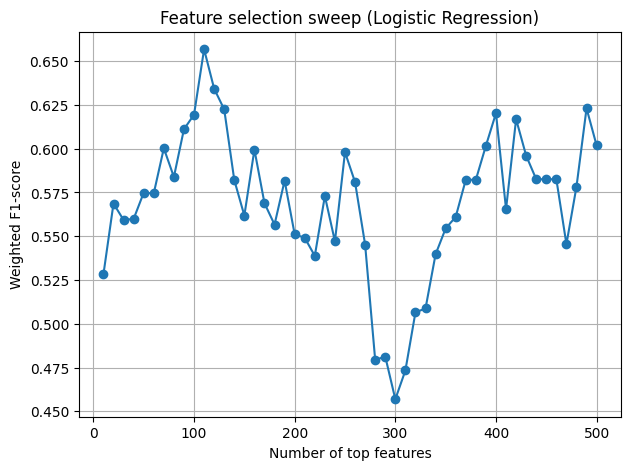

In [ ]:
plt.figure(figsize=(7,5))
plt.plot(results_df["n_features"], results_df["f1_weighted"], marker="o")
plt.xlabel("Number of top features")
plt.ylabel("Weighted F1-score")
plt.title("Feature selection sweep (Logistic Regression)")
plt.grid(True)
plt.show()


In [ ]:
top_features = global_imp.head(110).index

X_train_fs = X_train[top_features]
X_test_fs  = X_test[top_features]

scaler_fs = StandardScaler()
X_train_fs_sc = scaler_fs.fit_transform(X_train_fs)
X_test_fs_sc = scaler_fs.transform(X_test_fs)

model = LogisticRegression(
    max_iter=3000,
    class_weight="balanced",
    random_state=42
)

model.fit(X_train_fs_sc, y_train)

y_pred = model.predict(X_test_fs_sc)
y_proba = model.predict_proba(X_test_fs_sc)[:, 1]


print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         1.0       0.71      0.36      0.48        14
         2.0       0.72      0.76      0.74        37
         3.0       0.53      0.75      0.62        12

    accuracy                           0.67        63
   macro avg       0.65      0.62      0.61        63
weighted avg       0.68      0.67      0.66        63



## Linear regression

### Size

In [ ]:
X = df_whole.drop(columns=["patient_id", "size"])
y = df_whole["size"]


X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

model = LinearRegression()
model.fit(X_train_sc, y_train)
y_pred = model.predict(X_test_sc)

print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", mean_squared_error(y_test, y_pred))
print("R²:", r2_score(y_test, y_pred))


feature_importance = pd.DataFrame({
    "feature": X_train.columns,
    "coef": model.coef_,
    "abs_coef": np.abs(model.coef_)
}).sort_values("abs_coef", ascending=False)

feature_importance


MAE: 0.8617814188968167
RMSE: 1.1804762212579987
R²: -0.06673423846204574


feature          coef      abs_coef
3708     CHN2  1.580536e-02  1.580536e-02
3603     HAS1 -1.458725e-02  1.458725e-02
2802     PRG4 -1.446597e-02  1.446597e-02
4862  MAGEA11 -1.441656e-02  1.441656e-02
2676    APOC3  1.412067e-02  1.412067e-02
...       ...           ...           ...
5813   MAP3K6  6.450528e-07  6.450528e-07
1509     TPMT  5.940334e-07  5.940334e-07
1544    TRIP4  5.917410e-07  5.917410e-07
883      HSF1 -5.414168e-07  5.414168e-07
2         age -1.387779e-17  1.387779e-17

[6389 rows x 3 columns]

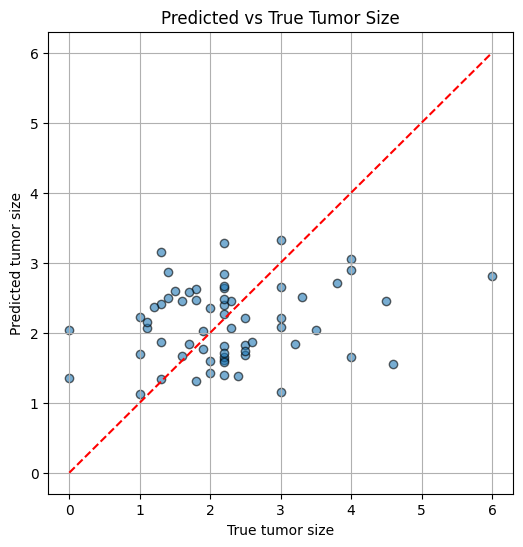

In [ ]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6, edgecolor="k")
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         "r--")
plt.xlabel("True tumor size")
plt.ylabel("Predicted tumor size")
plt.title("Predicted vs True Tumor Size")
plt.grid(True)
plt.show()


In [ ]:
from sklearn.linear_model import Lasso

In [ ]:
lasso_alpha = 0.01  # controls sparsity
model = Lasso(alpha=lasso_alpha, max_iter=10000, random_state=42)
model.fit(X_train_sc, y_train)
y_pred = model.predict(X_test_sc)

print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", mean_squared_error(y_test, y_pred))
print("R²:", r2_score(y_test, y_pred))


feature_importance = pd.DataFrame({
    "feature": X_train.columns,
    "coef": model.coef_,
    "abs_coef": np.abs(model.coef_)
}).sort_values("abs_coef", ascending=False)

feature_importance


MAE: 0.9880417829259543
RMSE: 1.529207494895963
R²: -0.3818643384276852


feature      coef  abs_coef
3603    HAS1 -0.181063  0.181063
5338  PRKAB2 -0.151888  0.151888
4000  GUCY2F -0.146122  0.146122
3708    CHN2  0.142547  0.142547
5181  CHI3L2 -0.113596  0.113596
...      ...       ...       ...
2143   RAMP1  0.000000  0.000000
2141  IL10RA  0.000000  0.000000
2140    DDX6 -0.000000  0.000000
2139    BCL3 -0.000000  0.000000
2153   PTPN2 -0.000000  0.000000

[6389 rows x 3 columns]

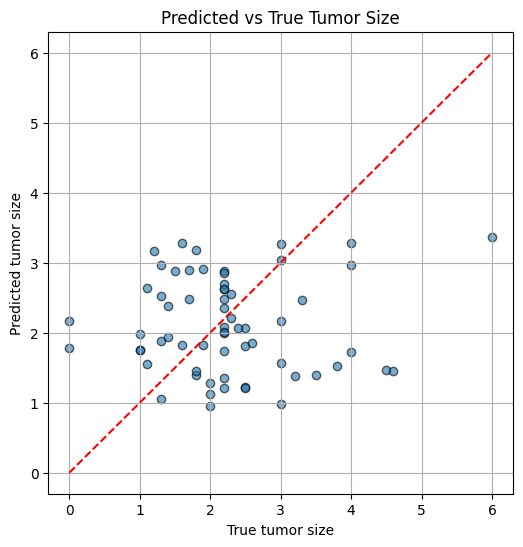

In [ ]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6, edgecolor="k")
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         "r--")
plt.xlabel("True tumor size")
plt.ylabel("Predicted tumor size")
plt.title("Predicted vs True Tumor Size")
plt.grid(True)
plt.show()


# Part IV — Evaluation

Design and justify a fair evaluation. Possible elements (choose and defend):

• A held-out test set, or (nested) cross-validation with clear separation of selection vs. assessment.

• Task-appropriate metrics for your classification models

• Simple baselines for context (e.g., majority class; a regularized linear model).

• Uncertainty/robustness: confidence intervals or bootstraps; sensitivity to key choices (e.g., representation, feature filter size, random seed).

• Use learning curves to assess data sufficiency; discuss whether more samples could improve performance.

### Er

In [ ]:
X = df_whole.drop(columns=["patient_id", "er"])
y = df_whole["er"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

smote = SMOTE(random_state=42)
X_train_os, y_train_os = smote.fit_resample(X_train, y_train)

In [ ]:
high_imp =   ['DKC1', 'ENSA', 'HMGCL', 'FGFR3', 'PDE4A', 'ESR1', 'ABL2', 'PCTK2', 'BRAP']

In [ ]:
X_train_os = X_train_os[high_imp]
X_test = X_test[high_imp]

train_pool = Pool(X_train_os, y_train_os, cat_features=cat_cols)
test_pool = Pool(X_test, y_test, cat_features=cat_cols)

model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.001,
    loss_function='MultiClass' if len(y.unique())>2 else 'Logloss',
    eval_metric='TotalF1',
    random_seed=42,
    verbose=False
)

model.fit(train_pool, eval_set=test_pool, early_stopping_rounds=50)

y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.9523809523809523
              precision    recall  f1-score   support

         0.0       0.88      0.78      0.82         9
         1.0       0.96      0.98      0.97        54

    accuracy                           0.95        63
   macro avg       0.92      0.88      0.90        63
weighted avg       0.95      0.95      0.95        63



In [ ]:


train_pool = Pool(X_train_os, y_train_os, cat_features=cat_cols)

# CatBoost parameters
params = {
    "iterations": 1000,
    "learning_rate": 0.001,
    "loss_function": "MultiClass" if len(y.unique()) > 2 else "Logloss",
    "eval_metric": "TotalF1",
    "random_seed": 42,
    "verbose": False
}

# Run cross-validation
cv_results = cv(
    params=params,
    pool=train_pool,
    fold_count=5,           # 5-fold CV
    stratified=True,
    shuffle=True,
    partition_random_seed=42,
    verbose=False
)

# Inspect results
cv_results.head()


Training on fold [0/5]

bestTest = 0.9180617939
bestIteration = 22

Training on fold [1/5]

bestTest = 0.9533875339
bestIteration = 314

Training on fold [2/5]

bestTest = 0.9534883721
bestIteration = 313

Training on fold [3/5]

bestTest = 0.9534632035
bestIteration = 113

Training on fold [4/5]

bestTest = 0.9650737783
bestIteration = 2



iterations  test-TotalF1-mean  test-TotalF1-std  train-TotalF1-mean  \
0           0           0.876312          0.013564            0.935978   
1           1           0.913884          0.024173            0.955782   
2           2           0.918514          0.029708            0.954037   
3           3           0.923096          0.029344            0.951721   
4           4           0.920729          0.025314            0.948813   

   train-TotalF1-std  test-Logloss-mean  test-Logloss-std  train-Logloss-mean  \
0           0.005481           0.691989          0.000106            0.691842   
1           0.013242           0.690648          0.000229            0.690394   
2           0.013409           0.689573          0.000260            0.689150   
3           0.010206           0.688400          0.000300            0.687885   
4           0.010610           0.687204          0.000409            0.686586   

   train-Logloss-std  
0           0.000026  
1           0.000097  
2           0.000119  
3           0.000147  
4           0.000147

Training on fold [0/5]



bestTest = 1
bestIteration = 2

Training on fold [1/5]



bestTest = 1
bestIteration = 2

Training on fold [2/5]



bestTest = 0.8366013072
bestIteration = 1

Training on fold [3/5]



bestTest = 1
bestIteration = 3

Training on fold [4/5]



bestTest = 0.9333333333
bestIteration = 0

Training on fold [0/5]

bestTest = 0.8729885057
bestIteration = 0

Training on fold [1/5]

bestTest = 0.9633922535
bestIteration = 135

Training on fold [2/5]

bestTest = 0.8956433637
bestIteration = 122

Training on fold [3/5]

bestTest = 0.9088888889
bestIteration = 4

Training on fold [4/5]

bestTest = 1
bestIteration = 745

Training on fold [0/5]

bestTest = 0.9166666667
bestIteration = 3

Training on fold [1/5]

bestTest = 0.9336533756
bestIteration = 1

Training on fold [2/5]

bestTest = 0.953698075
bestIteration = 61

Training on fold [3/5]

bestTest = 0.9778844585
bestIteration = 14

Training on fold [4/5]

bestTest = 0.914893617
bestIteration = 182

Training on fold [0/5]

bestTest = 0.8822771695
bestIteration = 0

Training on fold [1/5]

bestTest = 0.9851391303
bestIteration = 0

Training on fold [2/5]

bestTest = 0.9554173908
bestIteration = 224

Training on fold [3/5]

bestTest = 0.9849205446
bestIteration = 12

Training on fold [

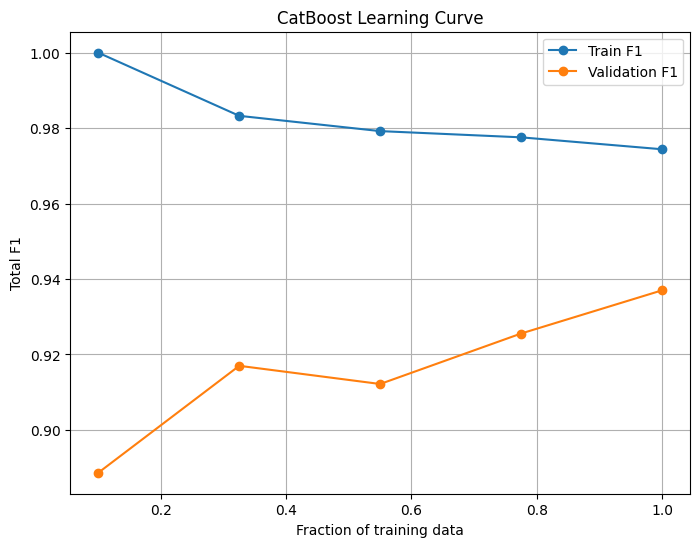

In [ ]:
train_sizes = np.linspace(0.1, 1.0, 5)  # 10%, 32%, 55%, 77%, 100%
train_scores = []
val_scores = []

for frac in train_sizes:
    # sample a fraction of training data
    n_samples = int(len(X_train_os) * frac)
    X_subset = X_train_os.iloc[:n_samples]
    y_subset = y_train_os.iloc[:n_samples]

    pool_subset = Pool(X_subset, y_subset, cat_features=cat_cols)

    # Run CV
    cv_results = cv(
        params=params,
        pool=pool_subset,
        fold_count=5,
        stratified=True,
        shuffle=True,
        partition_random_seed=42,
        verbose=False
    )

    # CatBoost cv returns a DataFrame with train and test metrics per iteration
    # Use the last iteration's mean metrics
    train_metric = cv_results['train-TotalF1-mean'].values[-1]
    val_metric = cv_results['test-TotalF1-mean'].values[-1]

    train_scores.append(train_metric)
    val_scores.append(val_metric)

plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_scores, marker='o', label='Train F1')
plt.plot(train_sizes, val_scores, marker='o', label='Validation F1')
plt.xlabel("Fraction of training data")
plt.ylabel("Total F1")
plt.title("CatBoost Learning Curve")
plt.grid(True)
plt.legend()
plt.show()


### Relapse

In [ ]:
high_imp = ['RPS24', 'AP2M1', 'CLTC', 'WARS', 'ACADVL', 'CCT7', 'TACC1', 'RAF1',
       'DKC1', 'TSN', 'LAMP1', 'ADNP', 'KIAA0494', 'ACAA1', 'IFRD1', 'MVP',
       'MAP2K2', 'GNAQ', 'EFNB1', 'PDCD4', 'HCLS1', 'IMPA1', 'UROS', 'VPS41',
       'IGFBP5', 'B3GAT3', 'LSM1', 'CD163', 'ITPR1', 'ERCC1', 'WWP2', 'SCG2',
       'CD37', 'SERPINB2', 'RAD51', 'GLI3', 'PARD6A', 'ZNF174', 'GJB3', 'ETV6',
       'ALDH3A1', 'SH3GL3', 'MMP3', 'PTX3', 'NRG1', 'PTAFR', 'PDK3', 'MYOD1',
       'SP4', 'FKBP6', 'ZNF124', 'SLC30A3', 'CDKN2A', 'ZNF223', 'ADCYAP1R1',
       'SIGLEC7', 'MMP8', 'MPL', 'TCL6', 'MCF2', 'ZNF157', 'ITGB6', 'DUX1',
       'RASGRP2', 'DRD4', 'GAGE1', 'ABCB11', 'UGT8', 'HPR', 'LMX1B', 'MTNR1B',
       'CCNI', 'PTRF', 'UROD', 'LMO4', 'PCYT2', 'PLD2', 'MYCN', 'NPAT',
       'TADA2L', 'EFNA3', 'NR5A1', 'CAMK4', 'GRB7', 'UBE3A', 'STX10', 'PMS1',
       'RALA', 'SLC5A4', 'ITM2B', 'NIT2', 'EHD3', 'USP25', 'CRTAC1', 'C1orf21',
       'ADAM30']

In [ ]:
X = df_whole.drop(columns=["patient_id", "relapse"])
y = df_whole["relapse"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

smote = SMOTE(random_state=42)
X_train_os, y_train_os = smote.fit_resample(X_train, y_train)


X_train_os = X_train_os[high_imp]
X_test = X_test[high_imp]

train_pool = Pool(X_train_os, y_train_os, cat_features=cat_cols)
test_pool = Pool(X_test, y_test, cat_features=cat_cols)

model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.0001,
    loss_function='MultiClass' if len(y.unique())>2 else 'Logloss',
    eval_metric='TotalF1',
    random_seed=42,
    verbose=False
)

model.fit(train_pool, eval_set=test_pool, early_stopping_rounds=50)

y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.7301587301587301
              precision    recall  f1-score   support

         0.0       0.79      0.84      0.82        45
         1.0       0.53      0.44      0.48        18

    accuracy                           0.73        63
   macro avg       0.66      0.64      0.65        63
weighted avg       0.72      0.73      0.72        63



In [ ]:
train_pool = Pool(X_train_os, y_train_os, cat_features=cat_cols)

# CatBoost parameters
params = {
    "iterations": 1000,
    "learning_rate": 0.0001,
    "loss_function": "MultiClass" if len(y.unique()) > 2 else "Logloss",
    "eval_metric": "TotalF1",
    "random_seed": 42,
    "verbose": False
}

# Run cross-validation
cv_results = cv(
    params=params,
    pool=train_pool,
    fold_count=5,           # 5-fold CV
    stratified=True,
    shuffle=True,
    partition_random_seed=42,
    verbose=False
)

# Inspect results
cv_results.head()


Training on fold [0/5]

bestTest = 0.8885448916
bestIteration = 30

Training on fold [1/5]

bestTest = 0.8888030888
bestIteration = 18

Training on fold [2/5]

bestTest = 0.8041958042
bestIteration = 58

Training on fold [3/5]

bestTest = 0.9722007722
bestIteration = 44

Training on fold [4/5]

bestTest = 0.8328173375
bestIteration = 619



iterations  test-TotalF1-mean  test-TotalF1-std  train-TotalF1-mean  \
0           0           0.672329          0.046472            0.780912   
1           1           0.726331          0.042772            0.852451   
2           2           0.706431          0.075815            0.874100   
3           3           0.731834          0.017879            0.882415   
4           4           0.767789          0.028679            0.894925   

   train-TotalF1-std  test-Logloss-mean  test-Logloss-std  train-Logloss-mean  \
0           0.016212           0.693121          0.000009            0.693100   
1           0.011492           0.693091          0.000017            0.693051   
2           0.015108           0.693068          0.000018            0.693010   
3           0.012716           0.693047          0.000014            0.692960   
4           0.017550           0.693017          0.000017            0.692918   

   train-Logloss-std  
0           0.000004  
1           0.000007  
2           0.000008  
3           0.000012  
4           0.000015

Training on fold [0/5]

bestTest = 0.75
bestIteration = 11

Training on fold [1/5]

bestTest = 0.75
bestIteration = 17

Training on fold [2/5]

bestTest = 0.8507936508
bestIteration = 3

Training on fold [3/5]

bestTest = 0.6714285714
bestIteration = 16

Training on fold [4/5]

bestTest = 1
bestIteration = 2

Training on fold [0/5]

bestTest = 0.7394957983
bestIteration = 1

Training on fold [1/5]

bestTest = 0.7222222222
bestIteration = 9

Training on fold [2/5]

bestTest = 0.6947368421
bestIteration = 13

Training on fold [3/5]

bestTest = 0.7391304348
bestIteration = 1

Training on fold [4/5]

bestTest = 0.7258297258
bestIteration = 57

Training on fold [0/5]

bestTest = 0.7099039172
bestIteration = 2

Training on fold [1/5]

bestTest = 0.71484375
bestIteration = 1

Training on fold [2/5]

bestTest = 0.6863553114
bestIteration = 1

Training on fold [3/5]

bestTest = 0.7028523068
bestIteration = 0

Training on fold [4/5]

bestTest = 0.6561771562
bestIteration = 46

Training on fold [

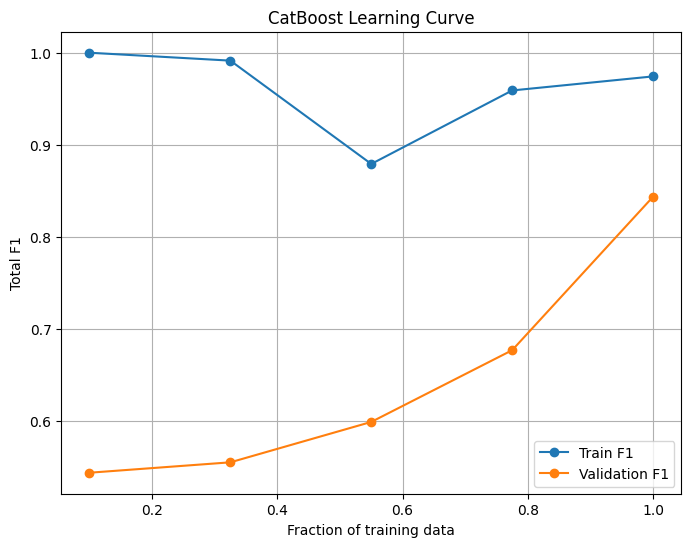

In [ ]:
train_sizes = np.linspace(0.1, 1.0, 5)
train_scores = []
val_scores = []

for frac in train_sizes:
    n_samples = int(len(X_train_os) * frac)
    X_subset = X_train_os.iloc[:n_samples]
    y_subset = y_train_os.iloc[:n_samples]

    pool_subset = Pool(X_subset, y_subset, cat_features=cat_cols)

    # Run CV
    cv_results = cv(
        params=params,
        pool=pool_subset,
        fold_count=5,
        stratified=True,
        shuffle=True,
        partition_random_seed=42,
        verbose=False
    )

    train_metric = cv_results['train-TotalF1-mean'].values[-1]
    val_metric = cv_results['test-TotalF1-mean'].values[-1]

    train_scores.append(train_metric)
    val_scores.append(val_metric)

plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_scores, marker='o', label='Train F1')
plt.plot(train_sizes, val_scores, marker='o', label='Validation F1')
plt.xlabel("Fraction of training data")
plt.ylabel("Total F1")
plt.title("CatBoost Learning Curve")
plt.grid(True)
plt.legend()
plt.show()


### Node

In [ ]:
high_imp =  ['grade', 'size', 'relapse', 'TRADD', 'NBL1', 'CTCF', 'MAP1A', 'ICA1',
       'CD44', 'HHEX', 'RAMP1', 'RAD51', 'SPINK5', 'INPP4B', 'AKAP5', 'RPS3',
       'CETN2', 'PIK3CB', 'AREG', 'SAMSN1']

In [ ]:
X = df_whole.drop(columns=["patient_id", "node"])
y = df_whole["node"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

smote = SMOTE(random_state=42)
X_train_os, y_train_os = smote.fit_resample(X_train, y_train)


X_train_os = X_train_os[high_imp]
X_test = X_test[high_imp]

train_pool = Pool(X_train_os, y_train_os, cat_features=cat_cols)
test_pool = Pool(X_test, y_test, cat_features=cat_cols)

model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.0001,
    loss_function='MultiClass' if len(y.unique())>2 else 'Logloss',
    eval_metric='TotalF1',
    random_seed=42,
    verbose=False
)

model.fit(train_pool, eval_set=test_pool, early_stopping_rounds=50)

y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.8571428571428571
              precision    recall  f1-score   support

         0.0       0.91      0.92      0.91        52
         1.0       0.60      0.55      0.57        11

    accuracy                           0.86        63
   macro avg       0.75      0.73      0.74        63
weighted avg       0.85      0.86      0.85        63




bestTest = 0.9634091923
bestIteration = 45

Training on fold [4/5]

bestTest = 0.9145197319
bestIteration = 72



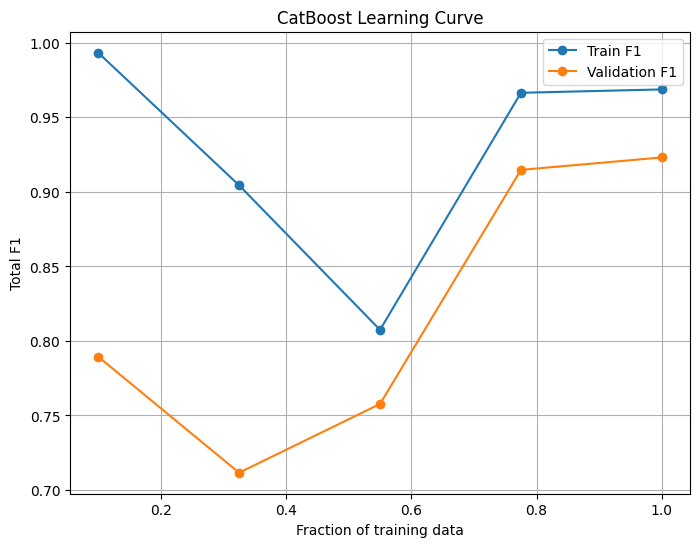

In [ ]:
train_sizes = np.linspace(0.1, 1.0, 5)
train_scores = []
val_scores = []

for frac in train_sizes:
    n_samples = int(len(X_train_os) * frac)
    X_subset = X_train_os.iloc[:n_samples]
    y_subset = y_train_os.iloc[:n_samples]

    pool_subset = Pool(X_subset, y_subset, cat_features=cat_cols)

    # Run CV
    cv_results = cv(
        params=params,
        pool=pool_subset,
        fold_count=5,
        stratified=True,
        shuffle=True,
        partition_random_seed=42,
        verbose=False
    )

    train_metric = cv_results['train-TotalF1-mean'].values[-1]
    val_metric = cv_results['test-TotalF1-mean'].values[-1]

    train_scores.append(train_metric)
    val_scores.append(val_metric)

plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_scores, marker='o', label='Train F1')
plt.plot(train_sizes, val_scores, marker='o', label='Validation F1')
plt.xlabel("Fraction of training data")
plt.ylabel("Total F1")
plt.title("CatBoost Learning Curve")
plt.grid(True)
plt.legend()
plt.show()


###Grade

In [ ]:
high_imp = ['node', 'size', 'MYBL2', 'BIRC5', 'U2AF1', 'SLC25A12', 'SKP2', 'MRPL12',
       'CKS2', 'MMP1', 'TTK', 'RAD51', 'CX3CR1', 'SLC24A1', 'GABRA6', 'CDKN3',
       'HN1', 'KIF4A', 'HPSE', 'C1orf21']


X = df_whole.drop(columns=["patient_id", "grade"])
y = df_whole["grade"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

smote = SMOTE(random_state=42)
X_train_os, y_train_os = smote.fit_resample(X_train, y_train)

X_train_os = X_train_os[high_imp]
X_test = X_test[high_imp]

train_pool = Pool(X_train_os, y_train_os, cat_features=cat_cols)
test_pool = Pool(X_test, y_test, cat_features=cat_cols)

model = CatBoostClassifier(
    iterations=800,
    learning_rate=0.0005,
    loss_function='MultiClass' if len(y.unique())>2 else 'Logloss',
    eval_metric='TotalF1',
    random_seed=42,
    verbose=False
)

model.fit(train_pool, eval_set=test_pool, early_stopping_rounds=50)

y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.6666666666666666
              precision    recall  f1-score   support

         1.0       0.50      0.86      0.63        14
         2.0       0.96      0.59      0.73        37
         3.0       0.50      0.67      0.57        12

    accuracy                           0.67        63
   macro avg       0.65      0.71      0.65        63
weighted avg       0.77      0.67      0.68        63




bestTest = 0.6843147277
bestIteration = 10

Training on fold [1/5]

bestTest = 0.821798061
bestIteration = 361

Training on fold [2/5]

bestTest = 0.8325347574
bestIteration = 832

Training on fold [3/5]

bestTest = 0.8125062174
bestIteration = 932

Training on fold [4/5]

bestTest = 0.7356643357
bestIteration = 770



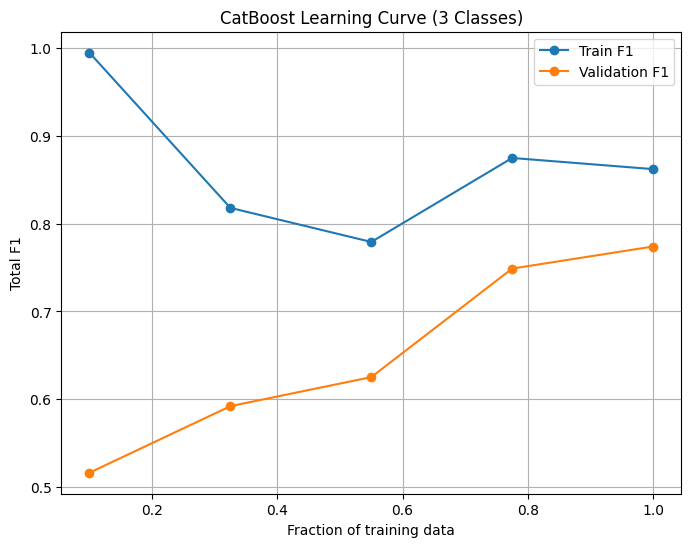

In [ ]:

params = {
    "iterations": 1000,
    "learning_rate": 0.001,
    "loss_function": "MultiClass",  # for 3 classes
    "eval_metric": "TotalF1",
    "random_seed": 42,
    "verbose": False
}


train_pool = Pool(X_train_os, y_train_os, cat_features=cat_cols)

train_sizes = np.linspace(0.1, 1.0, 5)
train_scores = []
val_scores = []

for frac in train_sizes:
    n_samples = int(len(X_train_os) * frac)
    X_subset = X_train_os.iloc[:n_samples]
    y_subset = y_train_os.iloc[:n_samples]

    pool_subset = Pool(X_subset, y_subset, cat_features=cat_cols)

    cv_results = cv(
        params=params,
        pool=pool_subset,
        fold_count=5,
        stratified=True,
        shuffle=True,
        partition_random_seed=42,
        verbose=False
    )

    train_metric = cv_results['train-TotalF1-mean'].values[-1]
    val_metric = cv_results['test-TotalF1-mean'].values[-1]

    train_scores.append(train_metric)
    val_scores.append(val_metric)


plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_scores, marker='o', label='Train F1')
plt.plot(train_sizes, val_scores, marker='o', label='Validation F1')
plt.xlabel("Fraction of training data")
plt.ylabel("Total F1")
plt.title("CatBoost Learning Curve (3 Classes)")
plt.grid(True)
plt.legend()
plt.show()


Trying even greater threasholds

The precision for class 1 is still too low

## Size

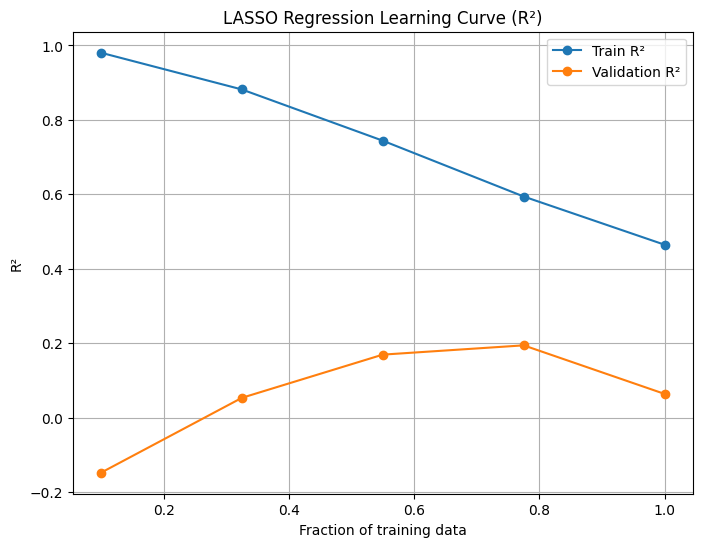

In [ ]:
from sklearn.linear_model import Lasso

X = df_whole.drop(columns=["patient_id", "size"])
y = df_whole["size"]

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Scale features
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)


train_sizes = np.linspace(0.1, 1.0, 5)  # 10%, 32%, 55%, 77%, 100%
train_mae = []
val_mae = []

train_rmse = []
val_rmse = []

train_r2 = []
val_r2 = []


lasso_alpha = 0.1  # controls sparsity

for frac in train_sizes:
    n_samples = int(len(X_train_sc) * frac)
    X_frac = X_train_sc[:n_samples]
    y_frac = y_train[:n_samples]

    model = Lasso(alpha=lasso_alpha, max_iter=10000, random_state=42)
    model.fit(X_frac, y_frac)

    # Predictions
    y_train_pred = model.predict(X_frac)
    y_val_pred = model.predict(X_test_sc)

    # Metrics
    train_mae.append(mean_absolute_error(y_frac, y_train_pred))
    val_mae.append(mean_absolute_error(y_test, y_val_pred))

    train_rmse.append(np.sqrt(mean_squared_error(y_frac, y_train_pred)))
    val_rmse.append(np.sqrt(mean_squared_error(y_test, y_val_pred)))

    train_r2.append(r2_score(y_frac, y_train_pred))
    val_r2.append(r2_score(y_test, y_val_pred))



plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_r2, marker='o', label='Train R²')
plt.plot(train_sizes, val_r2, marker='o', label='Validation R²')
plt.xlabel("Fraction of training data")
plt.ylabel("R²")
plt.title("LASSO Regression Learning Curve (R²)")
plt.grid(True)
plt.legend()
plt.show()


# Part V – LLMs-augmented analysis

Use a large language model (any general-purpose LLM, e.g., OpenAI GPT-class, Claude, Llama) as a research assistant to interpret your statistical and data-driven results. LLM outputs should be validated with conventional analyses and literature.

• Ask the LLM to propose a small, biologically plausible gene panel (e.g., 10–20 genes) to predict ER status, nodal status, or tumor size.

• Build classifiers using only these LLM-proposed features. Compare the LLM-augmented results to your baseline models from Part III as well as one dimensionality reduction method (performance, calibration, stability across CV folds).

• Deliverable: Performance comparison (all features vs. LLM features vs. reduced
dimension feature set).


## NODE

### LLM
I used ChatGPT 5.2

In [ ]:
df_whole.head(1)

patient_id  node  grade  size        age   er  relapse    DDR1    RFC2  \
0           0   0.0    2.0   0.0  58.666667  1.0      0.0  9.2048  6.3038   

    HSPA6  ...  CASP8AP2    POLM    KLK5  SH3BP4  SPO11    TRDN  DKFZP564C196  \
0  7.7602  ...    5.8878  2.5847  6.1013  8.4443  3.151  1.8322        3.3824   

    YDD19     TAZ   GMEB2  
0  3.7738  5.6098  7.2277  

[1 rows x 6391 columns]

In [ ]:
NODAL = ["MKI67", "CCNB1", "MMP11", "MMP9", "VIM", "CXCR4", "ITGA5", "COL1A1", "SPARC"] #" proposed['AURKA', 'CXCL12'] were not in the df
NODAL += ["node", "grade", "size", "age", "er", "relapse"]

In [ ]:
df_llm = df_whole[NODAL]
df_llm.head(1)

MKI67   CCNB1   MMP11    MMP9     VIM   CXCR4   ITGA5  COL1A1  SPARC  \
0  6.1573  6.5979  6.9193  6.6042  9.6882  6.8852  6.1789  9.6741  9.474   

   node  grade  size        age   er  relapse  
0   0.0    2.0   0.0  58.666667  1.0      0.0

In [ ]:
X = df_llm.drop(columns=["node"])
y = df_llm["node"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

smote = SMOTE(random_state=42)
X_train_os, y_train_os = smote.fit_resample(X_train, y_train)

In [ ]:
print("Before:", y_train.value_counts())
print("After:", y_train_os.value_counts())

Before: node
0.0    208
1.0     44
Name: count, dtype: int64
After: node
1.0    208
0.0    208
Name: count, dtype: int64


In [ ]:
train_pool = Pool(X_train_os, y_train_os)
test_pool = Pool(X_test, y_test)

model = CatBoostClassifier(
    iterations=2000,
    learning_rate=0.001,
    loss_function='MultiClass' if len(y.unique())>2 else 'Logloss',
    eval_metric='TotalF1',
    random_seed=42,
    verbose=False
)

model.fit(train_pool, eval_set=test_pool, early_stopping_rounds=50)

y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.746031746031746
              precision    recall  f1-score   support

         0.0       0.93      0.75      0.83        52
         1.0       0.38      0.73      0.50        11

    accuracy                           0.75        63
   macro avg       0.65      0.74      0.66        63
weighted avg       0.83      0.75      0.77        63



In [ ]:
importances = model.get_feature_importance()
feat_imp = pd.Series(importances, index=X_train.columns)

feat_imp.sort_values(ascending=False).head(15)

grade      39.298123
size       17.903725
relapse    15.401028
er         13.346276
CCNB1       8.449999
ITGA5       3.827934
CXCR4       1.772914
MMP9        0.000000
MMP11       0.000000
MKI67       0.000000
VIM         0.000000
COL1A1      0.000000
SPARC       0.000000
age         0.000000
dtype: float64

In [ ]:
NODAL = ["MKI67", "CCNB1", "MMP11", "MMP9", "VIM", "CXCR4", "ITGA5", "COL1A1", "SPARC"] #" proposed['AURKA', 'CXCL12'] were not in the df
NODAL += ["node"]

In [ ]:
df_llm = df_whole[NODAL]
df_llm.head(1)

MKI67   CCNB1   MMP11    MMP9     VIM   CXCR4   ITGA5  COL1A1  SPARC  node
0  6.1573  6.5979  6.9193  6.6042  9.6882  6.8852  6.1789  9.6741  9.474   0.0

In [ ]:
X = df_llm.drop(columns=["node"])
y = df_llm["node"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

smote = SMOTE(random_state=42)
X_train_os, y_train_os = smote.fit_resample(X_train, y_train)

In [ ]:
print("Before:", y_train.value_counts())
print("After:", y_train_os.value_counts())

Before: node
0.0    208
1.0     44
Name: count, dtype: int64
After: node
1.0    208
0.0    208
Name: count, dtype: int64


In [ ]:
train_pool = Pool(X_train_os, y_train_os)
test_pool = Pool(X_test, y_test)

model = CatBoostClassifier(
    iterations=2000,
    learning_rate=0.001,
    loss_function='MultiClass' if len(y.unique())>2 else 'Logloss',
    eval_metric='TotalF1',
    random_seed=42,
    verbose=False
)

model.fit(train_pool, eval_set=test_pool, early_stopping_rounds=50)

y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.7619047619047619
              precision    recall  f1-score   support

         0.0       0.86      0.85      0.85        52
         1.0       0.33      0.36      0.35        11

    accuracy                           0.76        63
   macro avg       0.60      0.60      0.60        63
weighted avg       0.77      0.76      0.77        63



In [ ]:
importances = model.get_feature_importance()
feat_imp = pd.Series(importances, index=X_train.columns)

feat_imp.sort_values(ascending=False).head(15)

SPARC     19.450696
CCNB1     15.886264
ITGA5     15.234893
MMP11     14.460109
MKI67     13.073162
VIM       10.424637
COL1A1     5.058082
CXCR4      4.408388
MMP9       2.003768
dtype: float64

### Dim-reduction

In [ ]:
X = df_whole.drop(columns=["patient_id", "node"])
y = df_whole["node"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

pca = PCA(n_components=140, random_state=42)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test )


smote = SMOTE(random_state=42)
X_train_os, y_train_os = smote.fit_resample(X_train, y_train)

In [ ]:
train_pool = Pool(X_train_os, y_train_os)
test_pool = Pool(X_test, y_test)

model = CatBoostClassifier(
    iterations=2000,
    learning_rate=0.001,
    loss_function='MultiClass' if len(y.unique())>2 else 'Logloss',
    eval_metric='TotalF1',
    random_seed=42,
    verbose=False
)

model.fit(train_pool, eval_set=test_pool, early_stopping_rounds=50)

y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.6031746031746031
              precision    recall  f1-score   support

         0.0       0.89      0.60      0.71        52
         1.0       0.25      0.64      0.36        11

    accuracy                           0.60        63
   macro avg       0.57      0.62      0.54        63
weighted avg       0.77      0.60      0.65        63

